# Data Understanding

| Feature                   | Description                                                                           | Example                   |
| ------------------------- | ------------------------------------------------------------------------------------- | ------------------------- |
| **timestamp_1h**          | The time of the record, grouped by hour. Used to track hourly network performance.    | `2025-10-25 14:00:00`     |
| **city**                  | The city where the network device is located.                                         | `Jakarta`                 |
| **city_key**              | A numerical ID representing the city.                                                 | `101`                     |
| **province**              | The province or state containing the city.                                            | `West Java`               |
| **region**                | A broader area grouping multiple provinces or cities.                                 | `Java Region`             |
| **olt_id**                | Identifier for the Optical Line Terminal (OLT) — a device managing fiber connections. | `OLT-XYZ-01`              |
| **olt_key**               | Numeric version of the OLT identifier.                                                | `1203`                    |
| **fdt_name**              | Fiber Distribution Terminal name — where fiber lines branch out to customers.         | `FDT-21`                  |
| **fat_name**              | Fiber Access Terminal name — smaller distribution point closer to end users.          | `FAT-14C`                 |
| **cluster_id**            | Identifier for a cluster or group of network devices monitored together.              | `CL-567`                  |
| **cluster_key**           | Numeric version of the cluster ID.                                                    | `567`                     |
| **cluster_name**          | Human-readable name for the cluster.                                                  | `Cluster Bandung-Central` |
| **ont_registered**        | Number of Optical Network Terminals (ONTs) registered under the OLT/cluster.          | `150`                     |
| **offline_ont_now**       | Number of ONTs currently offline.                                                     | `5`                       |
| **offline_ont_ratio**     | Proportion of offline ONTs to total registered ONTs.                                  | `0.033` (≈3.3%)           |
| **link_loss_count**       | Number of ONTs reporting link loss (no signal).                                       | `2`                       |
| **bad_rsl_count**         | Number of ONTs with poor signal strength (low receive signal level).                  | `3`                       |
| **high_temp_count**       | Number of ONTs with high temperature readings.                                        | `1`                       |
| **dying_gasp_count**      | Number of ONTs that sent a “dying gasp” — a signal before sudden power loss.          | `0`                       |
| **alarm_spike_flag**      | Indicates if a sudden rise in alarms occurred (1 = Yes, 0 = No).                      | `1`                       |
| **trap_trend_score**      | Statistical score showing recent increase or decrease in SNMP trap (alert) activity.  | `0.82`                    |
| **fault_rate**            | Calculated rate of faults across ONTs in the cluster.                                 | `0.12`                    |
| **snr_avg**               | Average Signal-to-Noise Ratio — higher is better signal quality.                      | `28.5`                    |
| **rx_power_avg**          | Average received power in milliwatts.                                                 | `0.002`                   |
| **rx_power_avg_dbm**      | Average received power in decibel-milliwatts (log scale).                             | `-27.0`                   |
| **temperature_avg_c**     | Average temperature in Celsius across devices.                                        | `35.2`                    |
| **temp_anomaly_score**    | Score indicating unusual temperature patterns.                                        | `0.6`                     |
| **hour_of_day**           | The hour extracted from the timestamp (0–23).                                         | `14`                      |
| **day_of_week**           | The day of the week as a number (e.g., 0 = Monday, 6 = Sunday).                       | `5`                       |
| **is_maintenance_window** | Whether the time falls within scheduled maintenance (1 = Yes, 0 = No).                | `0`                       |
| **label_outage_1h**       | Target label: whether an outage occurred within the next hour (1 = Yes, 0 = No).      | `1`                       |


# Loading the Dataset

In [1]:
import warnings
warnings.filterwarnings("ignore")

# Standard libraries
import json
import os
from collections import Counter, defaultdict, deque
from dotenv import load_dotenv

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# Scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    classification_report, roc_auc_score, average_precision_score,
    precision_recall_curve, roc_curve, brier_score_loss,
    confusion_matrix, ConfusionMatrixDisplay, make_scorer
)
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV

# Statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Gradient boosting libraries
from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier

# Model Persistence
import joblib

In [2]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
pd.set_option('display.max_columns', None)

# Connection to SnowFlake

In [3]:
# pip install snowflake-sqlalchemy

In [4]:
# # Database connection
# from sqlalchemy import create_engine, text

In [5]:
# load_dotenv()  # loads .env

# account   = os.getenv("SNOWFLAKE_ACCOUNT")
# user      = os.getenv("SNOWFLAKE_USER")
# password  = os.getenv("SNOWFLAKE_PASSWORD")
# role      = os.getenv("SNOWFLAKE_ROLE")
# warehouse = os.getenv("SNOWFLAKE_WAREHOUSE")
# database  = os.getenv("SNOWFLAKE_DATABASE")
# schema    = os.getenv("SNOWFLAKE_SCHEMA")

In [6]:
# # Build Snowflake SQLAlchemy URL
# engine = create_engine(
#     f"snowflake://{user}:{password}@{account}/{database}/{schema}?role={role}&warehouse={warehouse}"
# )

In [7]:
# # --- Adjust these to your table ---
# table_name = "EWS_ML_FEATURES_TABLE"

# # 2a) Quick peek (don’t pull the whole table yet)
# with engine.connect() as conn:
#     # preview_df = pd.read_sql(text(f"SELECT * FROM {table_name} LIMIT 5"), conn)
#     preview_df = pd.read_sql(text(f"SELECT * FROM {table_name}"), conn)

# preview_df.head()

Re-run

In [8]:
# df = preview_df.copy()

## Convert the EPOCH

In [9]:
# df['timestamp_1h'] = pd.to_datetime(df['timestamp_1h'], unit='ns')

In [10]:
# df.head()

In [11]:
# df.info()

# Local

In [12]:
df = pd.read_parquet('../! Generate Synthetic Dataset/dataset/ews_ml_features_table.parquet')

In [13]:
df.head()

,timestamp_1h,city,city_key,province,region,olt_id,olt_key,fdt_name,fat_name,cluster_id,cluster_key,cluster_name,ont_registered,offline_ont_now,offline_ont_ratio,link_loss_count,bad_rsl_count,high_temp_count,dying_gasp_count,alarm_spike_flag,trap_trend_score,fault_rate,snr_avg,rx_power_avg,rx_power_avg_dbm,temperature_avg_c,temp_anomaly_score,hour_of_day,day_of_week,is_maintenance_window,label_outage_1h
0,2023-01-01 00:00:00,Aceh,1,Aceh,Sumatra,OLT-ACE7E-01,1,FDT-ACE7E-01-A,FAT-ACE7E-01-B,ACE7E-CL11,1,Cluster-ACE7E-11,763,2,0.002194,0,0,0,1,0,0.0,0.001311,26.618261,-18.968959,-18.968959,39.449085,0.579634,0,6,0,0
1,2023-01-01 01:00:00,Aceh,1,Aceh,Sumatra,OLT-ACE7E-01,1,FDT-ACE7E-01-A,FAT-ACE7E-01-B,ACE7E-CL11,1,Cluster-ACE7E-11,763,8,0.010094,0,0,1,0,0,0.0,0.001311,25.090094,-18.079805,-18.079805,37.139484,-0.344206,1,6,0,0
2,2023-01-01 02:00:00,Aceh,1,Aceh,Sumatra,OLT-ACE7E-01,1,FDT-ACE7E-01-A,FAT-ACE7E-01-B,ACE7E-CL11,1,Cluster-ACE7E-11,763,0,0.000000,1,0,0,0,0,0.0,0.001311,25.094599,-17.933551,-17.933551,36.343299,-0.662680,2,6,0,0
3,2023-01-01 03:00:00,Aceh,1,Aceh,Sumatra,OLT-ACE7E-01,1,FDT-ACE7E-01-A,FAT-ACE7E-01-B,ACE7E-CL11,1,Cluster-ACE7E-11,763,3,0.004024,0,0,1,0,0,0.0,0.001311,27.886775,-17.946055,-17.946055,36.826140,-0.469544,3,6,0,0
4,2023-01-01 04:00:00,Aceh,1,Aceh,Sumatra,OLT-ACE7E-01,1,FDT-ACE7E-01-A,FAT-ACE7E-01-B,ACE7E-CL11,1,Cluster-ACE7E-11,763,1,0.001252,0,1,0,0,0,0.0,0.001311,25.742066,-18.768174,-18.768174,36.691094,-0.523562,4,6,0,0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3578976 entries, 0 to 3578975
Data columns (total 31 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   timestamp_1h           datetime64[ns]
 1   city                   object        
 2   city_key               int64         
 3   province               object        
 4   region                 object        
 5   olt_id                 object        
 6   olt_key                int64         
 7   fdt_name               object        
 8   fat_name               object        
 9   cluster_id             object        
 10  cluster_key            int64         
 11  cluster_name           object        
 12  ont_registered         int64         
 13  offline_ont_now        int64         
 14  offline_ont_ratio      float64       
 15  link_loss_count        int64         
 16  bad_rsl_count          int64         
 17  high_temp_count        int64         
 18  dying_gasp_count      

# Data Preprocessing

## Schema Check

In [15]:
# Expected columns
expected_cols = [
    'timestamp_1h','city','city_key','province','region','olt_id','olt_key',
    'fdt_name','fat_name','cluster_id','cluster_key','cluster_name',
    'ont_registered','offline_ont_now','offline_ont_ratio','link_loss_count',
    'bad_rsl_count','high_temp_count','dying_gasp_count','alarm_spike_flag',
    'trap_trend_score','fault_rate','snr_avg','rx_power_avg','rx_power_avg_dbm',
    'temperature_avg_c','temp_anomaly_score','hour_of_day','day_of_week',
    'is_maintenance_window','label_outage_1h'
]
missing = [c for c in expected_cols if c not in df.columns]
extra = [c for c in df.columns if c not in expected_cols]
print("Missing columns:", missing)
print("Extra columns:", extra)
assert not missing, "Dataset is missing required columns"

Missing columns: []
Extra columns: []


## Parse Time and Sort by Time

In [16]:
df.head(3)

,timestamp_1h,city,city_key,province,region,olt_id,olt_key,fdt_name,fat_name,cluster_id,cluster_key,cluster_name,ont_registered,offline_ont_now,offline_ont_ratio,link_loss_count,bad_rsl_count,high_temp_count,dying_gasp_count,alarm_spike_flag,trap_trend_score,fault_rate,snr_avg,rx_power_avg,rx_power_avg_dbm,temperature_avg_c,temp_anomaly_score,hour_of_day,day_of_week,is_maintenance_window,label_outage_1h
0,2023-01-01 00:00:00,Aceh,1,Aceh,Sumatra,OLT-ACE7E-01,1,FDT-ACE7E-01-A,FAT-ACE7E-01-B,ACE7E-CL11,1,Cluster-ACE7E-11,763,2,0.002194,0,0,0,1,0,0.0,0.001311,26.618261,-18.968959,-18.968959,39.449085,0.579634,0,6,0,0
1,2023-01-01 01:00:00,Aceh,1,Aceh,Sumatra,OLT-ACE7E-01,1,FDT-ACE7E-01-A,FAT-ACE7E-01-B,ACE7E-CL11,1,Cluster-ACE7E-11,763,8,0.010094,0,0,1,0,0,0.0,0.001311,25.090094,-18.079805,-18.079805,37.139484,-0.344206,1,6,0,0
2,2023-01-01 02:00:00,Aceh,1,Aceh,Sumatra,OLT-ACE7E-01,1,FDT-ACE7E-01-A,FAT-ACE7E-01-B,ACE7E-CL11,1,Cluster-ACE7E-11,763,0,0.000000,1,0,0,0,0,0.0,0.001311,25.094599,-17.933551,-17.933551,36.343299,-0.662680,2,6,0,0


In [17]:
df.tail(3)

,timestamp_1h,city,city_key,province,region,olt_id,olt_key,fdt_name,fat_name,cluster_id,cluster_key,cluster_name,ont_registered,offline_ont_now,offline_ont_ratio,link_loss_count,bad_rsl_count,high_temp_count,dying_gasp_count,alarm_spike_flag,trap_trend_score,fault_rate,snr_avg,rx_power_avg,rx_power_avg_dbm,temperature_avg_c,temp_anomaly_score,hour_of_day,day_of_week,is_maintenance_window,label_outage_1h
3578973,2024-12-31 21:00:00,Yogyakarta,34,Yogyakarta,Java,OLT-YOGA5-02,68,FDT-YOGA5-02-A,FAT-YOGA5-02-B,YOGA5-CL23,204,Cluster-YOGA5-23,673,3,0.004446,0,2,0,1,0,0.017831,0.004458,25.352138,-18.006144,-18.006144,38.062182,0.024873,21,1,0,0
3578974,2024-12-31 22:00:00,Yogyakarta,34,Yogyakarta,Java,OLT-YOGA5-02,68,FDT-YOGA5-02-A,FAT-YOGA5-02-B,YOGA5-CL23,204,Cluster-YOGA5-23,673,4,0.005462,1,0,0,1,0,-0.008915,0.002972,26.585605,-19.242656,-19.242656,37.258120,-0.296752,22,1,0,0
3578975,2024-12-31 23:00:00,Yogyakarta,34,Yogyakarta,Java,OLT-YOGA5-02,68,FDT-YOGA5-02-A,FAT-YOGA5-02-B,YOGA5-CL23,204,Cluster-YOGA5-23,674,0,0.000000,1,0,1,1,0,0.008876,0.004451,26.651386,-17.978085,-17.978085,38.430168,0.172067,23,1,0,0


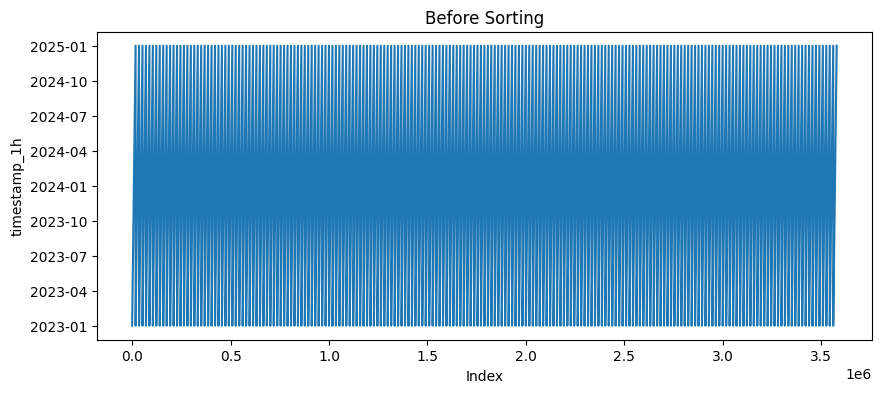

In [18]:
# Plot before sorting
plt.figure(figsize=(10, 4))
plt.plot(df['timestamp_1h'])
plt.title('Before Sorting')
plt.xlabel('Index')
plt.ylabel('timestamp_1h')
plt.show()

In [19]:
# Parse time
df['timestamp_1h'] = pd.to_datetime(df['timestamp_1h'], errors='coerce')
assert df['timestamp_1h'].notna().all(), "Some timestamps failed to parse"

In [20]:
# Sort by time for all downstream steps
df = df.sort_values('timestamp_1h').reset_index(drop=True)

In [21]:
df.describe()['timestamp_1h']

count                          3578976
mean     2024-01-01 11:29:59.999998720
min                2023-01-01 00:00:00
25%                2023-07-02 17:45:00
50%                2024-01-01 11:30:00
75%                2024-07-02 05:15:00
max                2024-12-31 23:00:00
std                                NaN
Name: timestamp_1h, dtype: object

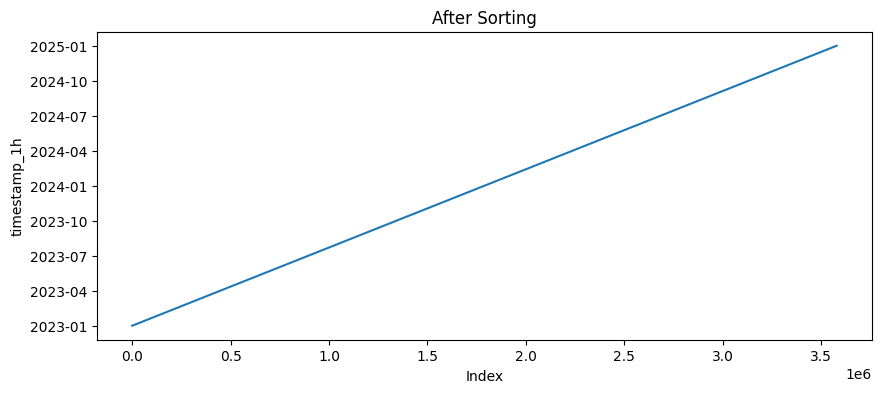

In [22]:
# Plot after sorting
plt.figure(figsize=(10, 4))
plt.plot(df['timestamp_1h'])
plt.title('After Sorting')
plt.xlabel('Index')
plt.ylabel('timestamp_1h')
plt.show()

In [23]:
df.head(1)

,timestamp_1h,city,city_key,province,region,olt_id,olt_key,fdt_name,fat_name,cluster_id,cluster_key,cluster_name,ont_registered,offline_ont_now,offline_ont_ratio,link_loss_count,bad_rsl_count,high_temp_count,dying_gasp_count,alarm_spike_flag,trap_trend_score,fault_rate,snr_avg,rx_power_avg,rx_power_avg_dbm,temperature_avg_c,temp_anomaly_score,hour_of_day,day_of_week,is_maintenance_window,label_outage_1h
0,2023-01-01,Aceh,1,Aceh,Sumatra,OLT-ACE7E-01,1,FDT-ACE7E-01-A,FAT-ACE7E-01-B,ACE7E-CL11,1,Cluster-ACE7E-11,763,2,0.002194,0,0,0,1,0,0.0,0.001311,26.618261,-18.968959,-18.968959,39.449085,0.579634,0,6,0,0


In [24]:
df.tail(1)

,timestamp_1h,city,city_key,province,region,olt_id,olt_key,fdt_name,fat_name,cluster_id,cluster_key,cluster_name,ont_registered,offline_ont_now,offline_ont_ratio,link_loss_count,bad_rsl_count,high_temp_count,dying_gasp_count,alarm_spike_flag,trap_trend_score,fault_rate,snr_avg,rx_power_avg,rx_power_avg_dbm,temperature_avg_c,temp_anomaly_score,hour_of_day,day_of_week,is_maintenance_window,label_outage_1h
3578975,2024-12-31 23:00:00,Yogyakarta,34,Yogyakarta,Java,OLT-YOGA5-02,68,FDT-YOGA5-02-A,FAT-YOGA5-02-B,YOGA5-CL23,204,Cluster-YOGA5-23,674,0,0.0,1,0,1,1,0,0.008876,0.004451,26.651386,-17.978085,-17.978085,38.430168,0.172067,23,1,0,0


## Handling Duplicate Data

In [25]:
df.duplicated().sum().sum()

np.int64(0)

## Handling Missing Values

In [26]:
df.isnull().sum().sum()

np.int64(0)

## Handling Error Data

In [27]:
df['city'].value_counts().sort_index()

city
Aceh                   105264
Bali                   105264
Bangka Belitung        105264
Banten                 105264
Bengkulu               105264
Gorontalo              105264
Jakarta Raya           105264
Jambi                  105264
Jawa Barat             105264
Jawa Tengah            105264
Jawa Timur             105264
Kalimantan Barat       105264
Kalimantan Selatan     105264
Kalimantan Tengah      105264
Kalimantan Timur       105264
Kalimantan Utara       105264
Kepulauan Riau         105264
Lampung                105264
Maluku                 105264
Maluku Utara           105264
Nusa Tenggara Barat    105264
Nusa Tenggara Timur    105264
Papua                  105264
Papua Barat            105264
Riau                   105264
Sulawesi Barat         105264
Sulawesi Selatan       105264
Sulawesi Tengah        105264
Sulawesi Tenggara      105264
Sulawesi Utara         105264
Sumatera Barat         105264
Sumatera Selatan       105264
Sumatera Utara         105264
Yogya

In [28]:
df['province'].value_counts().sort_index()

province
Aceh                   105264
Bali                   105264
Bangka Belitung        105264
Banten                 105264
Bengkulu               105264
Gorontalo              105264
Jakarta Raya           105264
Jambi                  105264
Jawa Barat             105264
Jawa Tengah            105264
Jawa Timur             105264
Kalimantan Barat       105264
Kalimantan Selatan     105264
Kalimantan Tengah      105264
Kalimantan Timur       105264
Kalimantan Utara       105264
Kepulauan Riau         105264
Lampung                105264
Maluku                 105264
Maluku Utara           105264
Nusa Tenggara Barat    105264
Nusa Tenggara Timur    105264
Papua                  105264
Papua Barat            105264
Riau                   105264
Sulawesi Barat         105264
Sulawesi Selatan       105264
Sulawesi Tengah        105264
Sulawesi Tenggara      105264
Sulawesi Utara         105264
Sumatera Barat         105264
Sumatera Selatan       105264
Sumatera Utara         105264
Y

In [29]:
df['region'].value_counts().sort_index()

region
Bali & Nusa Tenggara     315792
Java                     631584
Kalimantan               526320
Maluku                   210528
Papua                    210528
Sulawesi                 631584
Sumatra                 1052640
Name: count, dtype: int64

In [30]:
df['olt_id'].value_counts().sort_index()

olt_id
OLT-ACE7E-01    52632
OLT-ACE7E-02    52632
OLT-BAL53-01    52632
OLT-BAL53-02    52632
OLT-BAN02-01    52632
                ...  
OLT-SUMC0-02    52632
OLT-SUMFF-01    52632
OLT-SUMFF-02    52632
OLT-YOGA5-01    52632
OLT-YOGA5-02    52632
Name: count, Length: 68, dtype: int64

In [31]:
df['fdt_name'].value_counts().sort_index()

fdt_name
FDT-ACE7E-01-A    52632
FDT-ACE7E-02-A    52632
FDT-BAL53-01-A    52632
FDT-BAL53-02-A    52632
FDT-BAN02-01-A    52632
                  ...  
FDT-SUMC0-02-A    52632
FDT-SUMFF-01-A    52632
FDT-SUMFF-02-A    52632
FDT-YOGA5-01-A    52632
FDT-YOGA5-02-A    52632
Name: count, Length: 68, dtype: int64

In [32]:
df['fat_name'].value_counts().sort_index()

fat_name
FAT-ACE7E-01-B    52632
FAT-ACE7E-02-B    52632
FAT-BAL53-01-B    52632
FAT-BAL53-02-B    52632
FAT-BAN02-01-B    52632
                  ...  
FAT-SUMC0-02-B    52632
FAT-SUMFF-01-B    52632
FAT-SUMFF-02-B    52632
FAT-YOGA5-01-B    52632
FAT-YOGA5-02-B    52632
Name: count, Length: 68, dtype: int64

In [33]:
df['cluster_id'].value_counts().sort_index()

cluster_id
ACE7E-CL11    17544
ACE7E-CL12    17544
ACE7E-CL13    17544
ACE7E-CL21    17544
ACE7E-CL22    17544
              ...  
YOGA5-CL12    17544
YOGA5-CL13    17544
YOGA5-CL21    17544
YOGA5-CL22    17544
YOGA5-CL23    17544
Name: count, Length: 204, dtype: int64

In [34]:
df['cluster_name'].value_counts().sort_index()

cluster_name
Cluster-ACE7E-11    17544
Cluster-ACE7E-12    17544
Cluster-ACE7E-13    17544
Cluster-ACE7E-21    17544
Cluster-ACE7E-22    17544
                    ...  
Cluster-YOGA5-12    17544
Cluster-YOGA5-13    17544
Cluster-YOGA5-21    17544
Cluster-YOGA5-22    17544
Cluster-YOGA5-23    17544
Name: count, Length: 204, dtype: int64

## Converting Data Type

all good

## Timestamp monotonicity

Monotonic increasing (✅ good)  
10:00 → 11:00 → 12:00 → 13:00

In [35]:
is_monotonic = df['timestamp_1h'].is_monotonic_increasing
print("Timestamps monotonic increasing:", is_monotonic)

Timestamps monotonic increasing: True


## Range/Unit sanity checks (non-fatal warnings)

In [36]:
def warn_range(name, lower=None, upper=None):
    s = df[name].dropna()
    lo_ok = True if lower is None else (s.ge(lower).all())
    hi_ok = True if upper is None else (s.le(upper).all())
    if not lo_ok or not hi_ok:
        print(f"Range warning for {name}: min={s.min()}, max={s.max()}, expected [{lower}, {upper}]")

In [37]:
df.describe().loc[['min', 'mean', 'max']]

,timestamp_1h,city_key,olt_key,cluster_key,ont_registered,offline_ont_now,offline_ont_ratio,link_loss_count,bad_rsl_count,high_temp_count,dying_gasp_count,alarm_spike_flag,trap_trend_score,fault_rate,snr_avg,rx_power_avg,rx_power_avg_dbm,temperature_avg_c,temp_anomaly_score,hour_of_day,day_of_week,is_maintenance_window,label_outage_1h
min,2023-01-01 00:00:00,1.0,1.0,1.0,350.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,-0.167665,0.000000,15.873799,-24.892333,-24.892333,33.130329,-1.947868,0.0,0.000000,0.000000,0.000000
mean,2024-01-01 11:29:59.999998720,17.5,34.5,102.5,669.333427,3.569941,0.005331,0.441579,0.901482,0.402049,0.46142,0.017599,0.011538,0.003291,25.963916,-19.017676,-19.017676,37.644312,-0.142275,11.5,2.997264,0.002508,0.004125
max,2024-12-31 23:00:00,34.0,68.0,204.0,1010.000000,256.000000,0.277801,14.000000,15.000000,8.000000,10.00000,1.000000,2.000000,0.031936,31.264718,-15.775177,-15.775177,46.909531,3.563812,23.0,6.000000,1.000000,1.000000


In [38]:
warn_range('offline_ont_ratio', 0, 1)
warn_range('snr_avg', 10, 40)
warn_range('rx_power_avg_dbm', -35, -10)
warn_range('temperature_avg_c', 25, 70)
warn_range('hour_of_day', 0, 23)
warn_range('day_of_week', 0, 6)
warn_range('is_maintenance_window', 0, 1)
warn_range('alarm_spike_flag', 0, 1)
warn_range('label_outage_1h', 0, 1)

# Splitting the Dataset

**Time-aware split**: We’ll keep the last slice as test, the previous as validation, and the earlier as train, respecting chronology.

In [39]:
# Dataset split:
# - 20% for test
# - 10% of the remaining data for validation
# - 5% of the training data for calibration (make probability predictions more accurate)
test_frac = 0.20
val_frac  = 0.10
cal_frac  = 0.05

In [40]:
n = len(df)
test_cut = int(n * (1 - test_frac))
pre_test = df.iloc[:test_cut].copy()
test_df  = df.iloc[test_cut:].copy()

In [41]:
val_cut  = int(len(pre_test) * (1 - val_frac))
train_df = pre_test.iloc[:val_cut].copy()
val_df   = pre_test.iloc[val_cut:].copy()

In [42]:
cal_cut  = int(len(train_df) * (1 - cal_frac))
train_core = train_df.iloc[:cal_cut].copy()
cal_df     = train_df.iloc[cal_cut:].copy()

In [43]:
for name, df_ in [("train_core", train_core), ("cal", cal_df), ("val", val_df), ("test", test_df)]:
    print(name, df_['timestamp_1h'].min(), "→", df_['timestamp_1h'].max(), "rows:", len(df_))

train_core 2023-01-01 00:00:00 → 2024-05-15 00:00:00 rows: 2448018
cal 2024-05-15 00:00:00 → 2024-06-10 07:00:00 rows: 128844
val 2024-06-10 07:00:00 → 2024-08-07 19:00:00 rows: 286318
test 2024-08-07 19:00:00 → 2024-12-31 23:00:00 rows: 715796


In [44]:
def show_target(df, name):
    p = df['label_outage_1h'].mean()*100
    print(f"{name:<10} pos%={p:.4f}  (pos={df['label_outage_1h'].sum():,}, n={len(df):,})")

In [45]:
show_target(train_core, "train_core")
show_target(cal_df,     "cal")
show_target(val_df,     "val")
show_target(test_df,    "test")

train_core pos%=0.4133  (pos=10,118, n=2,448,018)
cal        pos%=0.4222  (pos=544, n=128,844)
val        pos%=0.4020  (pos=1,151, n=286,318)
test       pos%=0.4120  (pos=2,949, n=715,796)


# Data Visualization

## Handling Outliers

In [46]:
train_core.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2448018 entries, 0 to 2448017
Data columns (total 31 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   timestamp_1h           datetime64[ns]
 1   city                   object        
 2   city_key               int64         
 3   province               object        
 4   region                 object        
 5   olt_id                 object        
 6   olt_key                int64         
 7   fdt_name               object        
 8   fat_name               object        
 9   cluster_id             object        
 10  cluster_key            int64         
 11  cluster_name           object        
 12  ont_registered         int64         
 13  offline_ont_now        int64         
 14  offline_ont_ratio      float64       
 15  link_loss_count        int64         
 16  bad_rsl_count          int64         
 17  high_temp_count        int64         
 18  dying_gasp_count      

In [47]:
pd.options.display.float_format = '{:,.3f}'.format
train_core.describe()

,timestamp_1h,city_key,olt_key,cluster_key,ont_registered,offline_ont_now,offline_ont_ratio,link_loss_count,bad_rsl_count,high_temp_count,dying_gasp_count,alarm_spike_flag,trap_trend_score,fault_rate,snr_avg,rx_power_avg,rx_power_avg_dbm,temperature_avg_c,temp_anomaly_score,hour_of_day,day_of_week,is_maintenance_window,label_outage_1h
count,2448018,"2,448,018.000","2,448,018.000","2,448,018.000","2,448,018.000","2,448,018.000","2,448,018.000","2,448,018.000","2,448,018.000","2,448,018.000","2,448,018.000","2,448,018.000","2,448,018.000","2,448,018.000","2,448,018.000","2,448,018.000","2,448,018.000","2,448,018.000","2,448,018.000","2,448,018.000","2,448,018.000","2,448,018.000","2,448,018.000"
mean,2023-09-07 23:32:38.835596544,17.500,34.500,102.500,658.428,3.521,0.005,0.445,0.898,0.395,0.454,0.018,0.012,0.003,26.356,-18.806,-18.806,37.742,-0.103,11.500,2.996,0.003,0.004
min,2023-01-01 00:00:00,1.000,1.000,1.000,350.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.168,0.000,16.254,-24.742,-24.742,33.389,-1.845,0.000,0.000,0.000,0.000
25%,2023-05-06 00:00:00,9.000,18.000,52.000,522.000,1.000,0.001,0.000,0.000,0.000,0.000,0.000,-0.012,0.002,25.084,-19.451,-19.451,37.085,-0.366,5.000,1.000,0.000,0.000
50%,2023-09-08 00:00:00,17.500,34.500,102.500,655.000,2.000,0.004,0.000,1.000,0.000,0.000,0.000,0.000,0.003,26.625,-18.703,-18.703,37.717,-0.113,11.000,3.000,0.000,0.000
75%,2024-01-11 00:00:00,26.000,51.000,153.000,798.000,4.000,0.007,1.000,1.000,1.000,1.000,0.000,0.013,0.005,27.635,-18.138,-18.138,38.359,0.144,17.000,5.000,0.000,0.000
max,2024-05-15 00:00:00,34.000,68.000,204.000,972.000,256.000,0.278,14.000,15.000,8.000,9.000,1.000,2.000,0.032,31.265,-15.775,-15.775,46.910,3.564,23.000,6.000,1.000,1.000
std,NaN,9.811,19.628,58.889,154.629,10.278,0.015,0.701,1.021,0.658,0.718,0.133,0.109,0.002,1.615,0.885,0.885,1.003,0.401,6.922,2.005,0.051,0.064


In [48]:
# Numeric non-binary
selected_feats = [
    'ont_registered',
    'offline_ont_now',
    'offline_ont_ratio',
    'link_loss_count',
    'bad_rsl_count',
    'high_temp_count',
    'dying_gasp_count',
    'trap_trend_score',
    'fault_rate',
    'snr_avg',
    'rx_power_avg',
    'rx_power_avg_dbm',
    'temperature_avg_c',
    'temp_anomaly_score',
    'hour_of_day',
    'day_of_week'
]

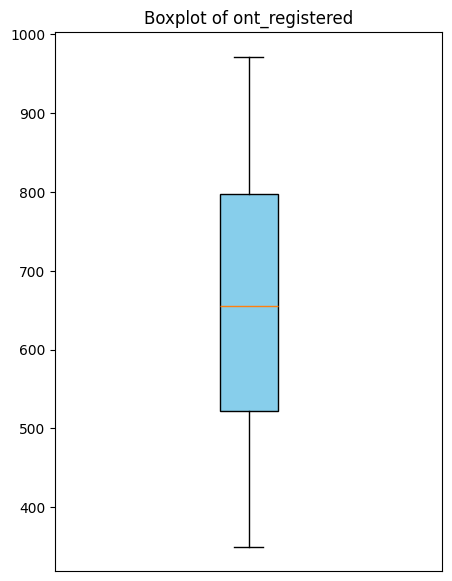

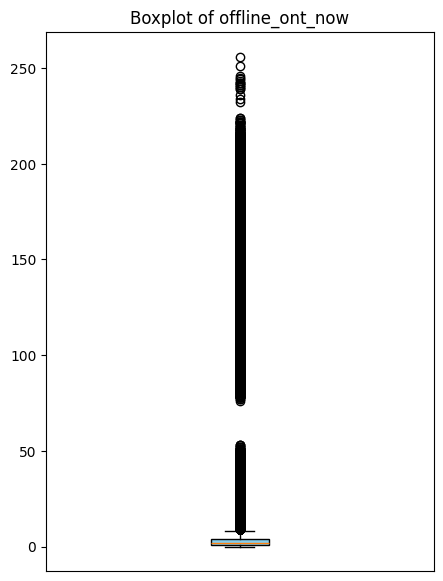

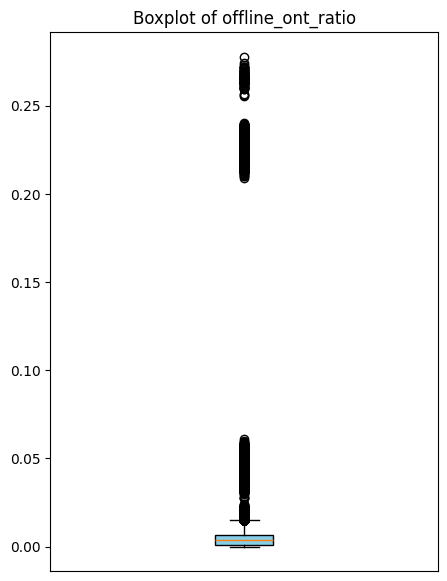

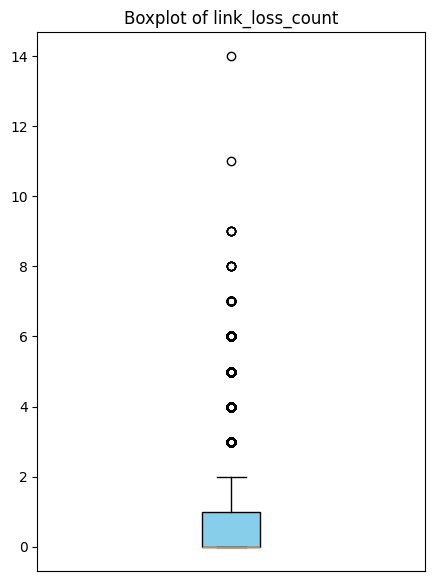

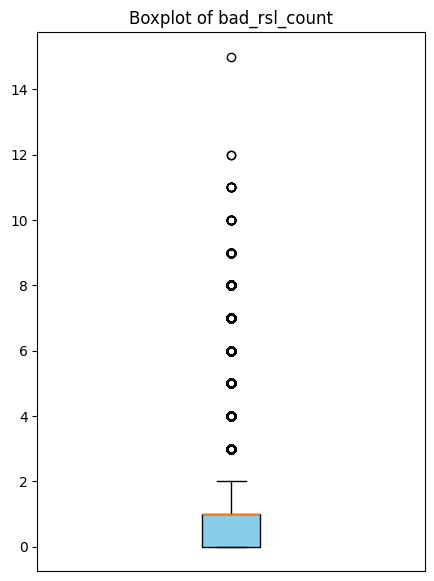

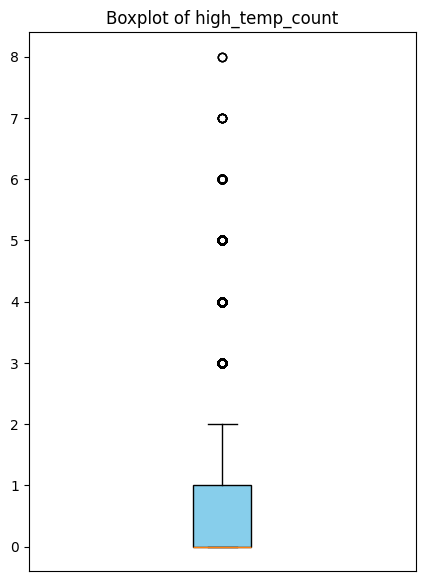

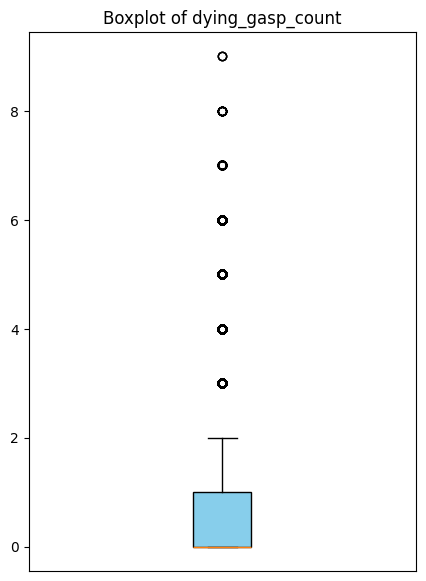

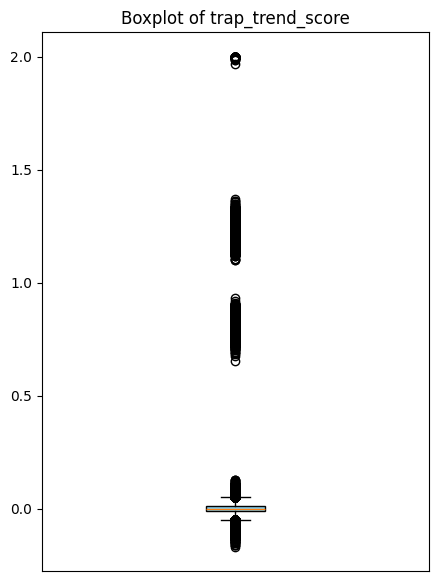

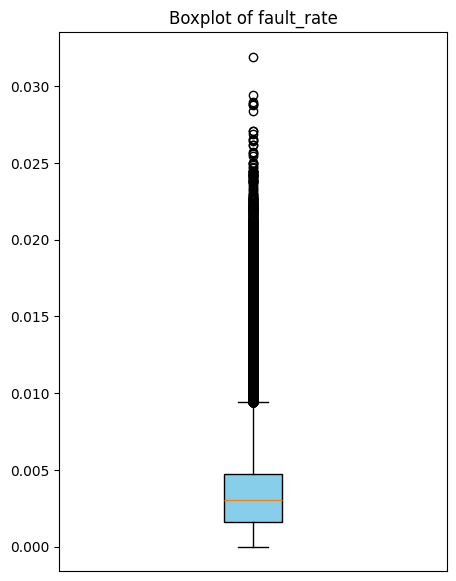

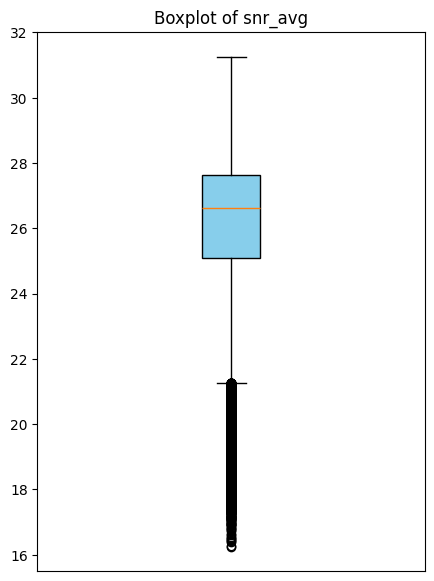

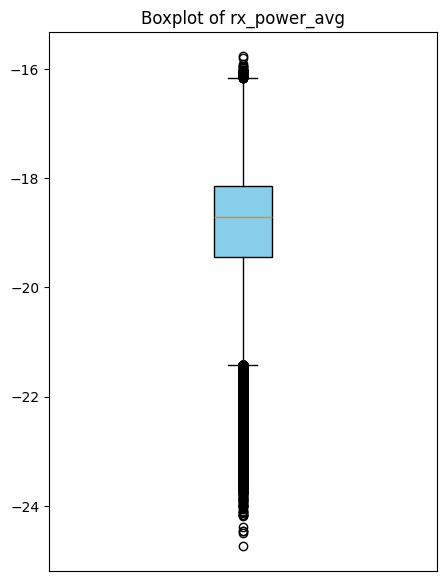

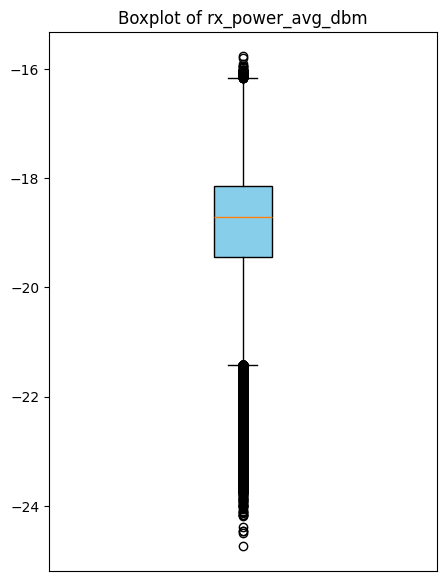

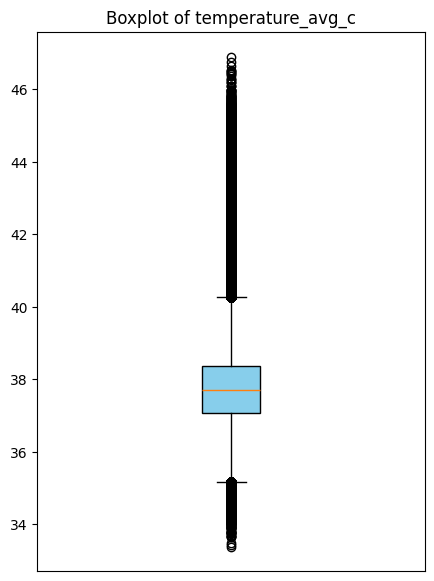

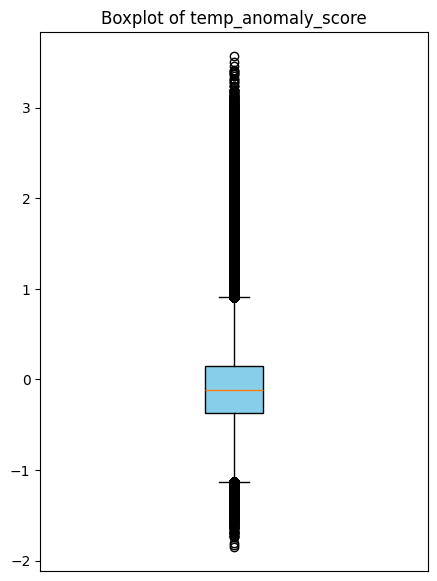

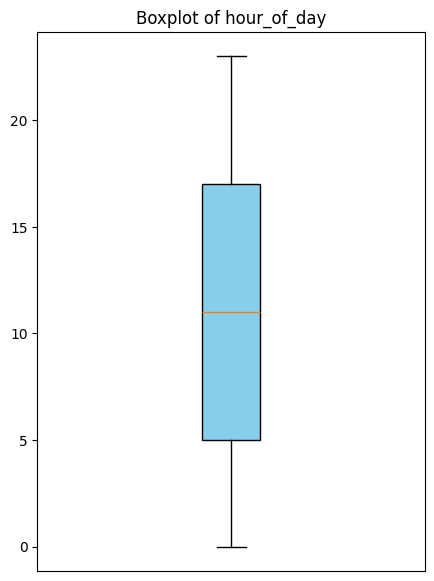

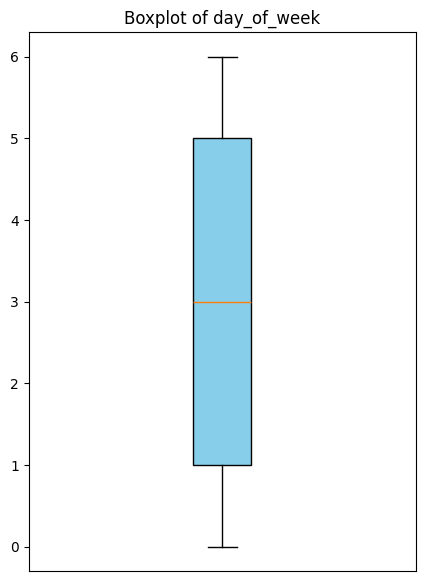

In [49]:
# Create individual boxplots
for feature in selected_feats:
    plt.figure(figsize=(5, 7))
    plt.boxplot(train_core[feature].dropna(), vert=True, patch_artist=True,
                boxprops=dict(facecolor="skyblue"))
    plt.title(f"Boxplot of {feature}")
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks([])
    plt.show()

In [50]:
train_core[train_core['offline_ont_ratio'] > 0.10]

,timestamp_1h,city,city_key,province,region,olt_id,olt_key,fdt_name,fat_name,cluster_id,cluster_key,cluster_name,ont_registered,offline_ont_now,offline_ont_ratio,link_loss_count,bad_rsl_count,high_temp_count,dying_gasp_count,alarm_spike_flag,trap_trend_score,fault_rate,snr_avg,rx_power_avg,rx_power_avg_dbm,temperature_avg_c,temp_anomaly_score,hour_of_day,day_of_week,is_maintenance_window,label_outage_1h
73,2023-01-01 00:00:00,Jawa Timur,11,Jawa Timur,Java,OLT-JAW87-02,22,FDT-JAW87-02-A,FAT-JAW87-02-B,JAW87-CL23,66,Cluster-JAW87-23,484,108,0.223,2,1,0,0,1,1.200,0.006,21.365,-21.031,-21.031,44.248,2.499,0,6,0,0
202,2023-01-01 00:00:00,Jawa Timur,11,Jawa Timur,Java,OLT-JAW87-01,21,FDT-JAW87-01-A,FAT-JAW87-01-B,JAW87-CL13,63,Cluster-JAW87-13,878,190,0.216,3,2,0,2,1,1.200,0.008,20.132,-20.953,-20.953,44.777,2.711,0,6,0,0
624,2023-01-01 03:00:00,Yogyakarta,34,Yogyakarta,Java,OLT-YOGA5-01,67,FDT-YOGA5-01-A,FAT-YOGA5-01-B,YOGA5-CL13,201,Cluster-YOGA5-13,791,178,0.226,1,4,0,2,1,1.223,0.009,20.998,-20.732,-20.732,43.075,2.030,3,6,0,0
889,2023-01-01 04:00:00,Maluku,19,Maluku,Maluku,OLT-MALDE-01,39,FDT-MALDE-01-A,FAT-MALDE-01-B,MALDE-CL12,116,Cluster-MALDE-12,767,172,0.224,1,1,0,1,1,1.184,0.004,20.967,-21.530,-21.530,43.890,2.356,4,6,0,0
1046,2023-01-01 05:00:00,Riau,25,Riau,Sumatra,OLT-RIAE4-02,50,FDT-RIAE4-02-A,FAT-RIAE4-02-B,RIAE4-CL22,149,Cluster-RIAE4-22,505,111,0.219,1,1,0,0,1,1.212,0.004,19.746,-20.643,-20.643,42.633,1.853,5,6,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2447168,2024-05-14 19:00:00,Jambi,8,Jambi,Sumatra,OLT-JAM02-01,15,FDT-JAM02-01-A,FAT-JAM02-01-B,JAM02-CL11,43,Cluster-JAM02-11,648,145,0.223,1,1,1,3,1,1.228,0.009,21.234,-21.255,-21.255,43.565,2.226,19,1,0,0
2447329,2024-05-14 20:00:00,Kalimantan Tengah,14,Kalimantan Tengah,Kalimantan,OLT-KAL57-01,23,FDT-KAL57-01-A,FAT-KAL57-01-B,KAL57-CL11,67,Cluster-KAL57-11,727,169,0.233,0,2,2,1,1,1.192,0.007,22.877,-22.436,-22.436,45.772,3.109,20,1,0,0
2447449,2024-05-14 21:00:00,Sulawesi Barat,26,Sulawesi Barat,Sulawesi,OLT-SUL6F-01,57,FDT-SUL6F-01-A,FAT-SUL6F-01-B,SUL6F-CL12,170,Cluster-SUL6F-12,410,94,0.229,2,3,0,0,1,1.244,0.012,22.492,-22.097,-22.097,45.514,3.006,21,1,0,0
2447488,2024-05-14 21:00:00,Papua Barat,24,Papua Barat,Papua,OLT-PAP80-01,47,FDT-PAP80-01-A,FAT-PAP80-01-B,PAP80-CL13,141,Cluster-PAP80-13,494,112,0.227,1,3,3,1,1,1.261,0.016,22.675,-21.757,-21.757,43.950,2.380,21,1,0,0


In [51]:
# Initialize all with None
capping_limits = {feature: None for feature in selected_feats}

In [52]:
capping_limits

{'ont_registered': None,
 'offline_ont_now': None,
 'offline_ont_ratio': None,
 'link_loss_count': None,
 'bad_rsl_count': None,
 'high_temp_count': None,
 'dying_gasp_count': None,
 'trap_trend_score': None,
 'fault_rate': None,
 'snr_avg': None,
 'rx_power_avg': None,
 'rx_power_avg_dbm': None,
 'temperature_avg_c': None,
 'temp_anomaly_score': None,
 'hour_of_day': None,
 'day_of_week': None}

In [53]:
capping_limits['ont_registered'] = [0, 100]
capping_limits['offline_ont_now'] = [0, 100] # extreme outliers, count
capping_limits['offline_ont_ratio'] = [0, 98] # extreme outliers
capping_limits['link_loss_count'] = [0, 100] # extreme outliers, count
capping_limits['bad_rsl_count'] = [0, 100] # extreme outliers, count
capping_limits['high_temp_count'] = [0, 100] # extreme outliers, count
capping_limits['dying_gasp_count'] = [0, 100] # extreme outliers, count
capping_limits['trap_trend_score'] = [1, 98] # extreme outliers
capping_limits['fault_rate'] = [0, 99.5] # extreme outliers
capping_limits['snr_avg'] = [0.5, 100] # extreme outliers
capping_limits['rx_power_avg'] = [0.15, 100] # extreme outliers
capping_limits['rx_power_avg_dbm'] = [0.15, 100] # extreme outliers
capping_limits['temperature_avg_c'] = [0.5, 99.5] # extreme outliers
capping_limits['temp_anomaly_score'] = [0.5, 99.5] # extreme outliers
capping_limits['hour_of_day'] = [0, 100]
capping_limits['day_of_week'] = [0, 100]

In [54]:
def cap_values(series, lower, upper):
    return np.clip(series, lower, upper)

In [55]:
caps = {}

for col, (low_p, high_p) in capping_limits.items():
    # Compute caps from TRAINING data only
    lower_cap = -np.inf if low_p == 0 else np.percentile(train_core[col], low_p)
    upper_cap = np.inf if high_p == 100 else np.percentile(train_core[col], high_p)
    caps[col] = (lower_cap, upper_cap)

    before_min, before_max = train_core[col].min(), train_core[col].max()
    num_low = (train_core[col] < lower_cap).sum()
    num_high = (train_core[col] > upper_cap).sum()

    print(f"\n[{col}]")
    print(f"  Before: min={before_min:.4f}, max={before_max:.4f}")
    print(f"  Caps: lower={lower_cap:.4f}, upper={upper_cap:.4f}")
    print(f"  Rows capped: low={num_low}, high={num_high}")

    for df in [train_core, cal_df, val_df, test_df]:
        df[col] = cap_values(df[col], lower_cap, upper_cap)

    after_min, after_max = train_core[col].min(), train_core[col].max()
    print(f"  After:  min={after_min:.4f}, max={after_max:.4f}")


[ont_registered]
  Before: min=350.0000, max=972.0000
  Caps: lower=-inf, upper=inf
  Rows capped: low=0, high=0
  After:  min=350.0000, max=972.0000

[offline_ont_now]
  Before: min=0.0000, max=256.0000
  Caps: lower=-inf, upper=inf
  Rows capped: low=0, high=0
  After:  min=0.0000, max=256.0000

[offline_ont_ratio]
  Before: min=0.0000, max=0.2778
  Caps: lower=-inf, upper=0.0135
  Rows capped: low=0, high=48961
  After:  min=0.0000, max=0.0135

[link_loss_count]
  Before: min=0.0000, max=14.0000
  Caps: lower=-inf, upper=inf
  Rows capped: low=0, high=0
  After:  min=0.0000, max=14.0000

[bad_rsl_count]
  Before: min=0.0000, max=15.0000
  Caps: lower=-inf, upper=inf
  Rows capped: low=0, high=0
  After:  min=0.0000, max=15.0000

[high_temp_count]
  Before: min=0.0000, max=8.0000
  Caps: lower=-inf, upper=inf
  Rows capped: low=0, high=0
  After:  min=0.0000, max=8.0000

[dying_gasp_count]
  Before: min=0.0000, max=9.0000
  Caps: lower=-inf, upper=inf
  Rows capped: low=0, high=0
  

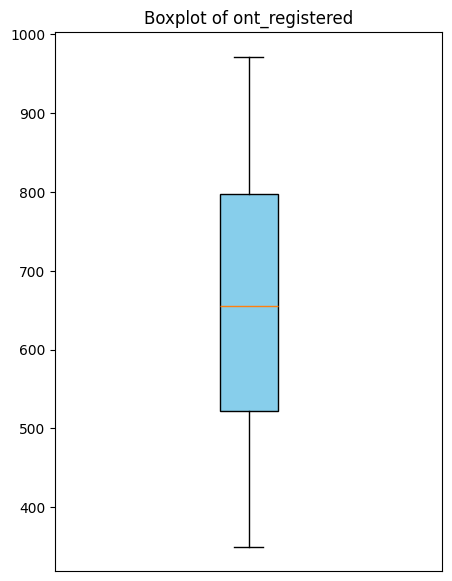

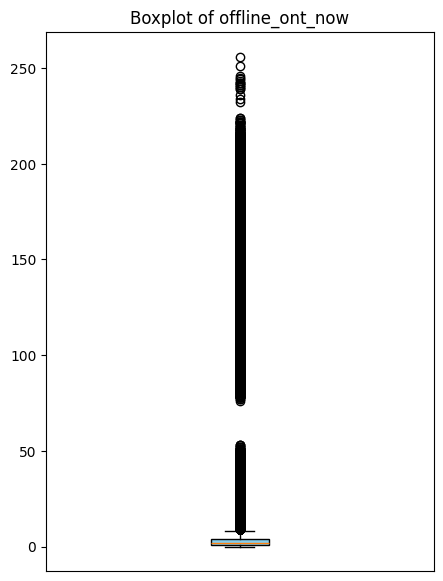

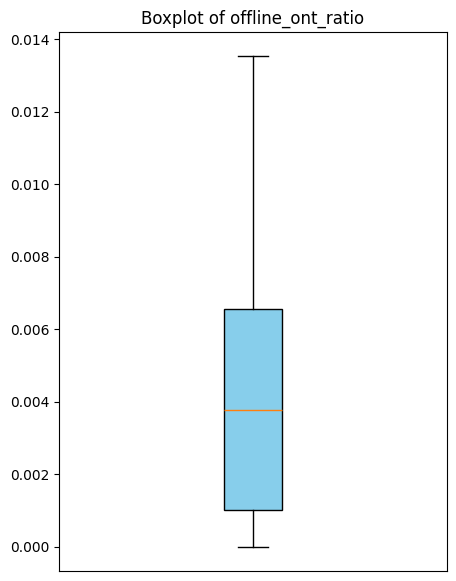

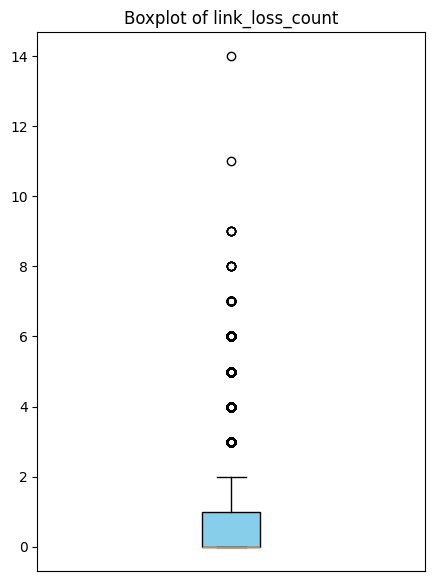

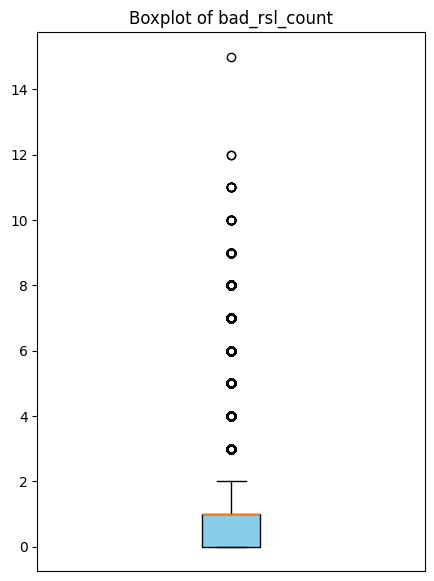

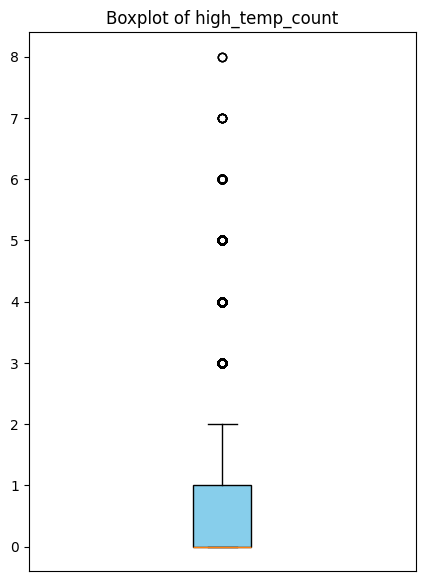

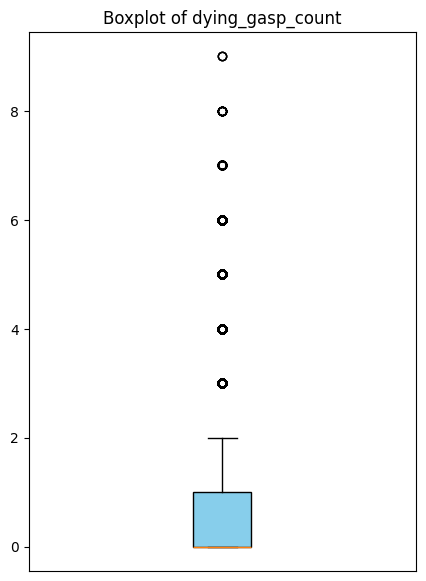

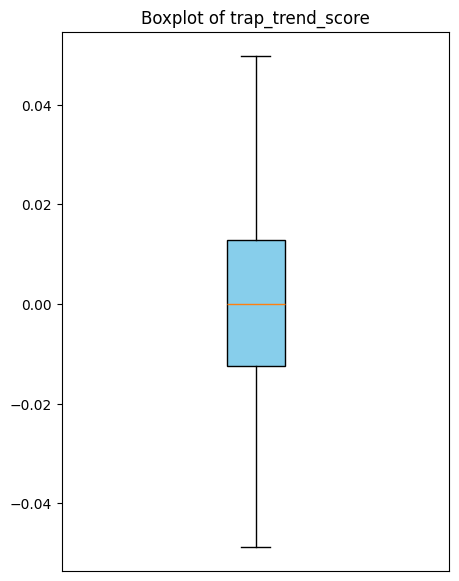

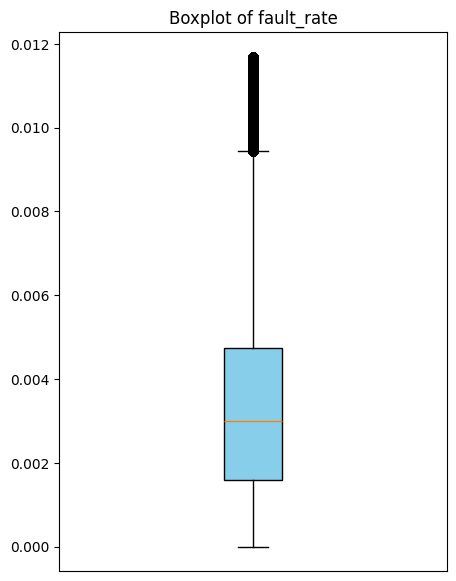

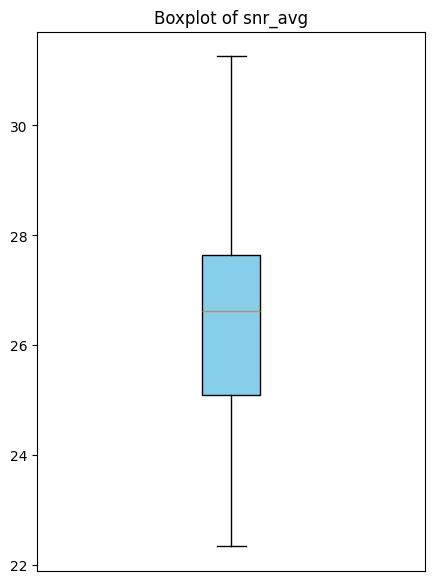

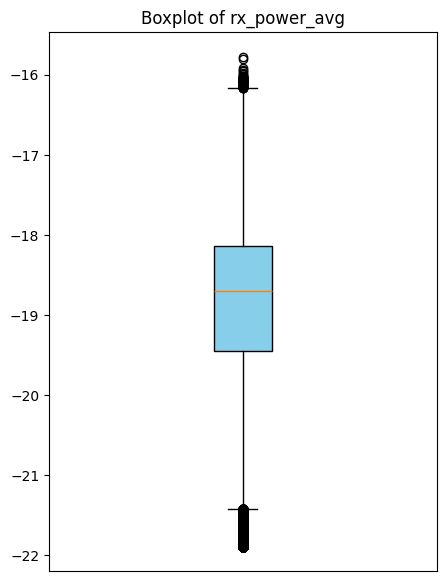

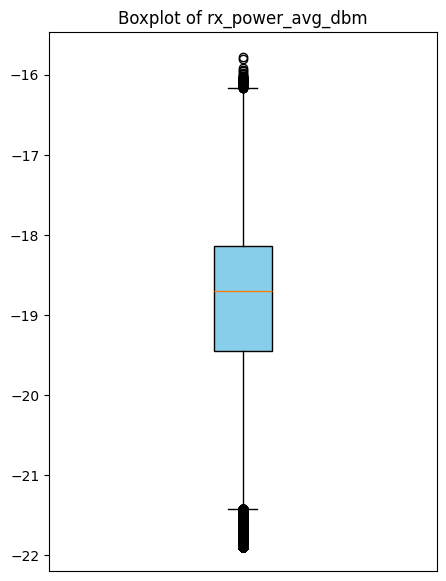

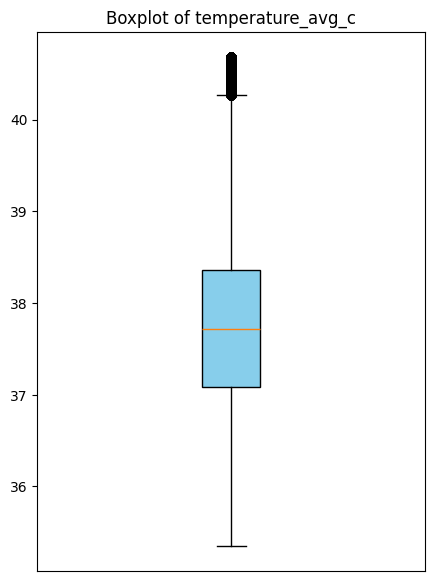

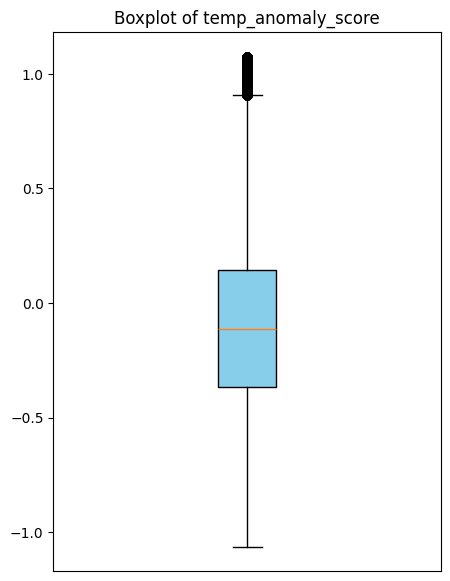

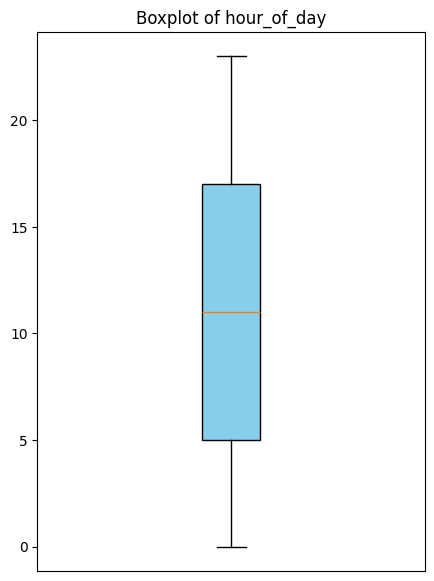

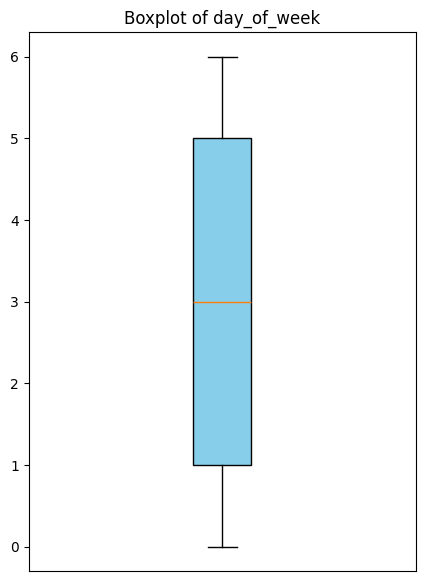

In [56]:
# Create individual boxplots
for feature in selected_feats:
    plt.figure(figsize=(5, 7))
    plt.boxplot(train_core[feature].dropna(), vert=True, patch_artist=True,
                boxprops=dict(facecolor="skyblue"))
    plt.title(f"Boxplot of {feature}")
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks([])
    plt.show()

## Handling Skewness

Skewness Interpretation
- 0 to ±0.5 → Nearly symmetric (No transformation needed)
- ±0.5 to ±1.0 → Moderately skewed (Mild transformation)
- \>±1.0 → Strongly skewed (Stronger transformation required)

In [57]:
# Compute skew only for non-binary numeric columns
skewed = train_core[selected_feats].skew().sort_values(ascending=True)
print(skewed)

snr_avg              -0.337
rx_power_avg         -0.333
rx_power_avg_dbm     -0.333
ont_registered       -0.008
hour_of_day           0.000
day_of_week           0.004
trap_trend_score      0.099
temp_anomaly_score    0.148
temperature_avg_c     0.148
offline_ont_ratio     0.649
fault_rate            0.758
bad_rsl_count         1.319
link_loss_count       1.762
dying_gasp_count      1.770
high_temp_count       1.808
offline_ont_now      14.060
dtype: float64


In [58]:
# The skewed count-like features
skewed_feats = ['offline_ont_now', 'bad_rsl_count', 'link_loss_count', 'dying_gasp_count', 'high_temp_count']

# Apply log1p transform safely (no drop)
for df in [train_core, cal_df, val_df, test_df]:
    for col in skewed_feats:
        # Clip negative values to 0 before log transform
        df[f'{col}_log'] = np.log1p(np.clip(df[col], 0, None))

In [59]:
# Build list of log-transformed feature names
skewed_feats_log = [f'{col}_log' for col in skewed_feats]

# Compute skew only for non-binary numeric columns (selected + log-transformed)
skewed = train_core[selected_feats + skewed_feats_log].skew().sort_values(ascending=True)

# Filter skewed Series to exclude features in skewed_feats
skewed_filtered = skewed[~skewed.index.isin(skewed_feats)]

# Print like a pandas Series
for feature, skew_value in skewed_filtered.items():
    print(f"{feature:<20} {skew_value:.3f}")

snr_avg              -0.337
rx_power_avg         -0.333
rx_power_avg_dbm     -0.333
ont_registered       -0.008
hour_of_day          0.000
day_of_week          0.004
trap_trend_score     0.099
temp_anomaly_score   0.148
temperature_avg_c    0.148
bad_rsl_count_log    0.361
offline_ont_now_log  0.413
offline_ont_ratio    0.649
fault_rate           0.758
link_loss_count_log  1.018
dying_gasp_count_log 1.027
high_temp_count_log  1.136


- Skew around 1 is not a problem for **tree-based models**.
- The log transform is already reasonable and should stabilize training and feature effects.

In [60]:
# Drop them manually from each dataframe
for df in [train_core, cal_df, val_df, test_df]:
    df.drop(columns=skewed_feats, inplace=True)

In [61]:
train_core.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2448018 entries, 0 to 2448017
Data columns (total 31 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   timestamp_1h           datetime64[ns]
 1   city                   object        
 2   city_key               int64         
 3   province               object        
 4   region                 object        
 5   olt_id                 object        
 6   olt_key                int64         
 7   fdt_name               object        
 8   fat_name               object        
 9   cluster_id             object        
 10  cluster_key            int64         
 11  cluster_name           object        
 12  ont_registered         int64         
 13  offline_ont_ratio      float64       
 14  alarm_spike_flag       int64         
 15  trap_trend_score       float64       
 16  fault_rate             float64       
 17  snr_avg                float64       
 18  rx_power_avg          

In [62]:
train_core.columns

Index(['timestamp_1h', 'city', 'city_key', 'province', 'region', 'olt_id',
       'olt_key', 'fdt_name', 'fat_name', 'cluster_id', 'cluster_key',
       'cluster_name', 'ont_registered', 'offline_ont_ratio',
       'alarm_spike_flag', 'trap_trend_score', 'fault_rate', 'snr_avg',
       'rx_power_avg', 'rx_power_avg_dbm', 'temperature_avg_c',
       'temp_anomaly_score', 'hour_of_day', 'day_of_week',
       'is_maintenance_window', 'label_outage_1h', 'offline_ont_now_log',
       'bad_rsl_count_log', 'link_loss_count_log', 'dying_gasp_count_log',
       'high_temp_count_log'],
      dtype='object')

In [63]:
cal_df.columns

Index(['timestamp_1h', 'city', 'city_key', 'province', 'region', 'olt_id',
       'olt_key', 'fdt_name', 'fat_name', 'cluster_id', 'cluster_key',
       'cluster_name', 'ont_registered', 'offline_ont_ratio',
       'alarm_spike_flag', 'trap_trend_score', 'fault_rate', 'snr_avg',
       'rx_power_avg', 'rx_power_avg_dbm', 'temperature_avg_c',
       'temp_anomaly_score', 'hour_of_day', 'day_of_week',
       'is_maintenance_window', 'label_outage_1h', 'offline_ont_now_log',
       'bad_rsl_count_log', 'link_loss_count_log', 'dying_gasp_count_log',
       'high_temp_count_log'],
      dtype='object')

In [64]:
cal_df.shape, val_df.shape, test_df.shape

((128844, 31), (286318, 31), (715796, 31))

## Target Distribution

In [65]:
def target_dist(df, col_target, target_1_label='Positive', target_0_label='Negative'):
    mpl.rcParams['font.size'] = 11

    # Count values
    r = df[col_target].value_counts().sort_index()
    total = r.sum()
    
    # Labels match order of index (0, 1)
    labels = [target_0_label if i == 0 else target_1_label for i in r.index]
    
    # Custom function for percentage + count with thousand separator
    def make_autopct(values):
        def my_autopct(pct):
            val = int(round(pct * total / 100.0))
            return f"{pct:.1f}%\n({val:,})"
        return my_autopct

    # Create pie chart
    fig, ax = plt.subplots(figsize=(4, 4))
    wedges, texts, autotexts = ax.pie(
        r,
        explode=[0.05, 0.1],
        labels=labels,
        radius=1.5,
        autopct=make_autopct(r),
        shadow=True,
        startangle=45,
        colors=['#66b3ff', '#ff9999'],
        textprops={'color': 'black'}
    )

    # Styling
    ax.set_aspect('equal')
    ax.set_frame_on(False)
    plt.setp(autotexts, size=10, weight="bold", color="white")

    # Add space between title and chart
    plt.title(f"Distribution of {col_target} (Train set)", fontweight="bold", fontsize=13, pad=40)

    plt.tight_layout()
    plt.show()

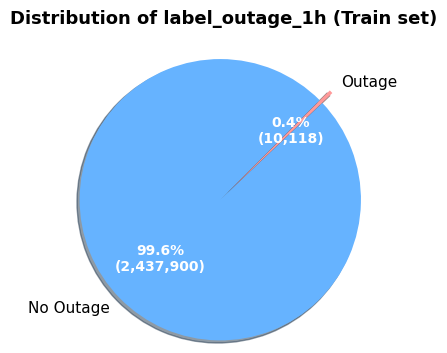

In [66]:
target_dist(train_core, 'label_outage_1h', target_1_label='Outage', target_0_label='No Outage')

## Categorical Data vs Target

In [67]:
def prop_agg(df, y, x):
  temp_df = df.groupby([y,x], as_index = False).size()
  temp_df['prop'] = temp_df['size'] / temp_df.groupby(y)['size'].transform('sum')
  return temp_df

In [68]:
prop_agg(train_core, "region", "label_outage_1h")

,region,label_outage_1h,size,prop
0,Bali & Nusa Tenggara,0,215148,0.996
1,Bali & Nusa Tenggara,1,855,0.004
2,Java,0,430221,0.996
3,Java,1,1784,0.004
4,Kalimantan,0,358452,0.996
5,Kalimantan,1,1551,0.004
6,Maluku,0,143450,0.996
7,Maluku,1,550,0.004
8,Papua,0,143400,0.996
9,Papua,1,600,0.004


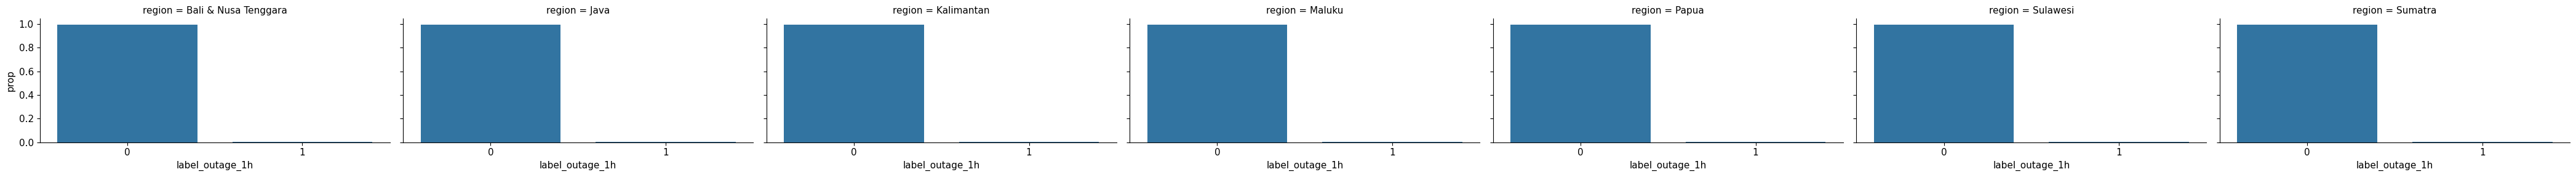

In [69]:
g = sns.FacetGrid(
    data = prop_agg(train_core, "region", "label_outage_1h"),
    col = "region",
    aspect = 2
)
g.map(sns.barplot, "label_outage_1h", "prop");

## Numerical Data vs Target

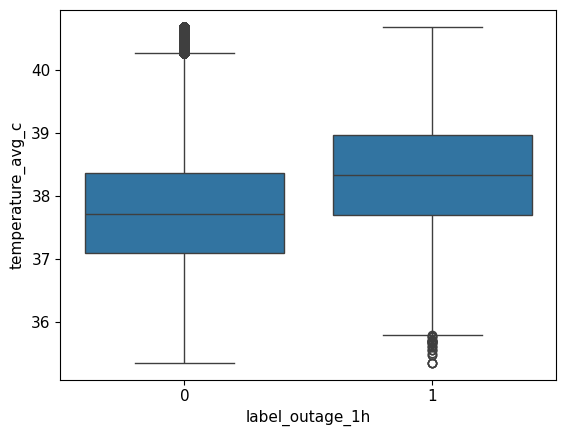

In [70]:
sns.boxplot(x = "label_outage_1h", y = "temperature_avg_c", data = train_core);

# Feature Building

- Rolling sums over 6h and 24h per olt_id for key event counts.
- One-step deltas (current − previous hour) per olt_id.
- Cyclical time features from hour_of_day.
- Frequency encodings for a few categorical columns to avoid huge one-hot vectors.

## Helper functions for features

In [71]:
GROUP_KEY = 'olt_id'
ROLL_KEYS = [
    'link_loss_count_log','bad_rsl_count_log','high_temp_count_log',
    'dying_gasp_count_log','offline_ont_now_log'
]

**Converts specified columns of a DataFrame to numeric values, replacing any non-numeric entries or infinities with NaN**

In [72]:
def _safe_numeric(df, cols):
    f = df.copy()
    for c in cols:
        if c in f.columns:
            f[c] = pd.to_numeric(f[c], errors='coerce')
    # Replace inf/-inf from logs, then fill NaN later
    f.replace([np.inf, -np.inf], np.nan, inplace=True)
    return f

**Cylical Encoding**

In [73]:
def add_time_feats(f):
    f = f.copy()
    f['hour_sin'] = np.sin(2*np.pi * f['hour_of_day']/24.0)
    f['hour_cos'] = np.cos(2*np.pi * f['hour_of_day']/24.0)
    return f

**Rolling Sums**

In [74]:
def add_roll_delta(f, group_key=GROUP_KEY, windows=(6, 24)):
    f = _safe_numeric(f, ROLL_KEYS)
    f = f.sort_values(['timestamp_1h', group_key]).copy()
    # Deltas on LOG-space (interpretable as multiplicative change)
    for col in ROLL_KEYS:
        if col in f.columns:
            f[col + "_delta_1h"] = f.groupby(group_key)[col].diff().astype(float)
    # Rolling means on LOG-space (smooths multiplicative noise)
    for w in windows:
        for col in ROLL_KEYS:
            if col in f.columns:
                f[f"{col}_roll{w}h_mean"] = (
                    f.groupby(group_key)[col]
                     .rolling(w, min_periods=1).mean()
                     .reset_index(level=0, drop=True)
                     .astype(float)
                )
    return f

In [75]:
def prepare_block(df):
    f = add_time_feats(df)
    # ensure *_log present; if not, warn minimally
    missing_logs = [c for c in ROLL_KEYS if c not in f.columns]
    if missing_logs:
        print("WARNING: missing log columns:", missing_logs)
    return f

## Build features on train/val/test separately (to avoid leakage)

In [76]:
# Prepare blocks
train_core_f = prepare_block(train_core)
cal_f        = prepare_block(cal_df)
val_f        = prepare_block(val_df)
test_f       = prepare_block(test_df)

In [77]:
train_core_f.head().iloc[:, -8:]

,label_outage_1h,offline_ont_now_log,bad_rsl_count_log,link_loss_count_log,dying_gasp_count_log,high_temp_count_log,hour_sin,hour_cos
0,0,1.099,0.000,0.000,0.693,0.000,0.000,1.000
1,0,1.792,1.386,0.000,0.000,0.000,0.000,1.000
2,0,2.398,0.693,0.693,0.000,0.693,0.000,1.000
3,0,0.000,0.693,0.000,0.693,0.693,0.000,1.000
4,0,0.693,0.693,0.000,0.000,0.693,0.000,1.000


In [78]:
# Compute roll/delta chronologically across all to avoid leakage
concat_all = pd.concat([train_core_f, cal_f, val_f, test_f], axis=0).sort_values('timestamp_1h')
concat_all = add_roll_delta(concat_all, group_key=GROUP_KEY, windows=(6,24))

In [79]:
train_core_f = concat_all.loc[train_core_f.index].copy()
cal_f        = concat_all.loc[cal_f.index].copy()
val_f        = concat_all.loc[val_f.index].copy()
test_f       = concat_all.loc[test_f.index].copy()

In [80]:
train_core_f.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2448018 entries, 0 to 2448017
Data columns (total 48 columns):
 #   Column                             Dtype         
---  ------                             -----         
 0   timestamp_1h                       datetime64[ns]
 1   city                               object        
 2   city_key                           int64         
 3   province                           object        
 4   region                             object        
 5   olt_id                             object        
 6   olt_key                            int64         
 7   fdt_name                           object        
 8   fat_name                           object        
 9   cluster_id                         object        
 10  cluster_key                        int64         
 11  cluster_name                       object        
 12  ont_registered                     int64         
 13  offline_ont_ratio                  float64       
 14  alarm_s

In [81]:
# Base numeric (no raw IDs)
num_base = [
    'offline_ont_ratio','trap_trend_score','fault_rate',
    'snr_avg','rx_power_avg_dbm','temperature_avg_c','temp_anomaly_score',
    'hour_sin','hour_cos','is_maintenance_window'
]

In [82]:
# Build feature list: *_log deltas/rollings + base
roll_cols = [c for c in train_core_f.columns if any(s in c for s in [
    "_delta_1h","_roll6h_mean","_roll24h_mean"
]) and any(c.startswith(k) for k in ROLL_KEYS)]

In [83]:
feature_cols_all = [c for c in num_base if c in train_core_f.columns] + roll_cols

In [84]:
# Clean NaNs from log ops later during matrix build
target_col = 'label_outage_1h'
print("Num features:", len(feature_cols_all))
print(sorted(feature_cols_all)[:12], "...")

Num features: 25
['bad_rsl_count_log_delta_1h', 'bad_rsl_count_log_roll24h_mean', 'bad_rsl_count_log_roll6h_mean', 'dying_gasp_count_log_delta_1h', 'dying_gasp_count_log_roll24h_mean', 'dying_gasp_count_log_roll6h_mean', 'fault_rate', 'high_temp_count_log_delta_1h', 'high_temp_count_log_roll24h_mean', 'high_temp_count_log_roll6h_mean', 'hour_cos', 'hour_sin'] ...


In [85]:
train_core_f.shape, cal_f.shape, val_f.shape, test_f.shape

((2448018, 48), (128844, 48), (286318, 48), (715796, 48))

In [86]:
train_core_f[feature_cols_all].info()

<class 'pandas.core.frame.DataFrame'>
Index: 2448018 entries, 0 to 2448017
Data columns (total 25 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   offline_ont_ratio                  float64
 1   trap_trend_score                   float64
 2   fault_rate                         float64
 3   snr_avg                            float64
 4   rx_power_avg_dbm                   float64
 5   temperature_avg_c                  float64
 6   temp_anomaly_score                 float64
 7   hour_sin                           float64
 8   hour_cos                           float64
 9   is_maintenance_window              int64  
 10  link_loss_count_log_delta_1h       float64
 11  bad_rsl_count_log_delta_1h         float64
 12  high_temp_count_log_delta_1h       float64
 13  dying_gasp_count_log_delta_1h      float64
 14  offline_ont_now_log_delta_1h       float64
 15  link_loss_count_log_roll6h_mean    float64
 16  bad_rsl_count_log_roll6

# Multicollinearity Check

## Correlation Matrix

I group the correlation strength into the following categories:
- Strong: Correlation strength ≥ 0.8 or ≤ -0.8
- Moderate: 0.3 < correlation strength < 0.8 or -0.8 < correlation strength < -0.3
- Weak: Correlation strength ≤ 0.3 and ≥ -0.3

In [87]:
def get_strong_correlations(df, threshold=0.7):

    # Select only numeric columns
    df_numeric = df.select_dtypes(include=['number'])
    
    # Calculate correlation matrix
    corr_matrix = df_numeric.corr()
    
    # Get upper triangle of correlation matrix without diagonal (to avoid self/redundant pairs)
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Unstack and sort by absolute correlation
    corr_pairs = upper_triangle.unstack().dropna().sort_values(key=abs, ascending=False)
    
    # Filter by threshold
    strong_corrs = corr_pairs[(corr_pairs >= threshold) | (corr_pairs <= -threshold)]
    
    # Convert to DataFrame for better presentation
    result_df = pd.DataFrame(strong_corrs).reset_index()
    result_df.columns = ['Feature 1', 'Feature 2', 'Correlation']
    
    # Sort by absolute correlation value
    result_df['Abs_Correlation'] = result_df['Correlation'].abs()
    result_df = result_df.sort_values('Abs_Correlation', ascending=False).drop('Abs_Correlation', axis=1)
    
    return result_df

In [88]:
get_strong_correlations(train_core_f[feature_cols_all])

,Feature 1,Feature 2,Correlation
0,temp_anomaly_score,temperature_avg_c,1.000


In [89]:
col_to_drop = ['temp_anomaly_score']

In [90]:
# col_to_drop.extend(['xx', 'yy'])

In [91]:
# Drop the column in-place for each DataFrame
for df in [train_core_f, cal_f, val_f, test_f]:
    df.drop(columns=col_to_drop, inplace=True)

## Reassign Features Cols All

In [92]:
feature_cols_all = [col for col in feature_cols_all if col not in col_to_drop]

In [93]:
get_strong_correlations(train_core_f[feature_cols_all])

,Feature 1,Feature 2,Correlation


In [94]:
train_core_f[feature_cols_all].info()

<class 'pandas.core.frame.DataFrame'>
Index: 2448018 entries, 0 to 2448017
Data columns (total 24 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   offline_ont_ratio                  float64
 1   trap_trend_score                   float64
 2   fault_rate                         float64
 3   snr_avg                            float64
 4   rx_power_avg_dbm                   float64
 5   temperature_avg_c                  float64
 6   hour_sin                           float64
 7   hour_cos                           float64
 8   is_maintenance_window              int64  
 9   link_loss_count_log_delta_1h       float64
 10  bad_rsl_count_log_delta_1h         float64
 11  high_temp_count_log_delta_1h       float64
 12  dying_gasp_count_log_delta_1h      float64
 13  offline_ont_now_log_delta_1h       float64
 14  link_loss_count_log_roll6h_mean    float64
 15  bad_rsl_count_log_roll6h_mean      float64
 16  high_temp_count_log_rol

## VIF

**Only for Logistic Regression**

I group the strength of VIF into the following categories:
- No multicollinearity: VIF = 1
- Moderate multicollinearity: 5 ≤ VIF ≤ 10
- Severe multicollinearity: VIF > 10

Calculate the VIF only for variables with a correlation strength greater than 0.3

In [95]:
def calculate_vif(data, target_col='TARGET', corr_threshold=0.3):

    # Drop the target column and keep only numeric features
    X = data.drop(columns=target_col, errors='ignore')
    X = X.select_dtypes(include='number')
    
    # Correlation matrix and selecting highly correlated features
    corr_matrix = X.corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    high_corr_features = [col for col in upper_tri.columns if any(upper_tri[col] > corr_threshold)]
    
    # Subset and clean the data
    X_vif = X[high_corr_features]

    # Handle infs and NaNs
    # Temporary imputation for missing values (just for VIF)
    X_vif = X_vif.replace([np.inf, -np.inf], np.nan).fillna(X_vif.median(numeric_only=True))
    
    # Add constant for VIF computation
    X_vif = add_constant(X_vif)
    
    # Compute VIF
    vif_df = pd.DataFrame({
        "feature": X_vif.columns,
        "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
    })
    
    # Drop the constant and sort by VIF
    vif_df = vif_df[vif_df.feature != 'const'].sort_values(by='VIF', ascending=False).reset_index(drop=True)
    
    return vif_df

In [96]:
%%time
vif_results = calculate_vif(train_core_f[feature_cols_all], target_col='label_outage_1h')

CPU times: total: 43.5 s
Wall time: 33.8 s


In [97]:
vif_results

,feature,VIF
0,offline_ont_now_log_roll24h_mean,1.691
1,fault_rate,1.470
2,offline_ont_now_log_roll6h_mean,1.463
3,bad_rsl_count_log_delta_1h,1.278
4,bad_rsl_count_log_roll24h_mean,1.225
5,dying_gasp_count_log_delta_1h,1.135
6,link_loss_count_log_roll24h_mean,1.125
7,high_temp_count_log_roll24h_mean,1.071
8,dying_gasp_count_log_roll24h_mean,1.050
9,rx_power_avg_dbm,1.038


# Model Building

## Metrics

In [98]:
def make_xy(frame, feats, target):
    X = frame[feats].copy()
    # Replace NaNs introduced by logs/diffs/rolling
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0.0).astype(float)
    y = frame[target].astype(int)
    return X, y

In [99]:
X_tr, y_tr = make_xy(train_core_f, feature_cols_all, target_col)
X_cal, y_cal = make_xy(cal_f, feature_cols_all, target_col)
X_va,  y_va  = make_xy(val_f,  feature_cols_all, target_col)
X_te,  y_te  = make_xy(test_f, feature_cols_all, target_col)

In [100]:
print("Shapes:", X_tr.shape, X_cal.shape, X_va.shape, X_te.shape)

Shapes: (2448018, 24) (128844, 24) (286318, 24) (715796, 24)


## Convert Number Dtype

To reduce memory usage (bytes per number)

In [101]:
X_tr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2448018 entries, 0 to 2448017
Data columns (total 24 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   offline_ont_ratio                  float64
 1   trap_trend_score                   float64
 2   fault_rate                         float64
 3   snr_avg                            float64
 4   rx_power_avg_dbm                   float64
 5   temperature_avg_c                  float64
 6   hour_sin                           float64
 7   hour_cos                           float64
 8   is_maintenance_window              float64
 9   link_loss_count_log_delta_1h       float64
 10  bad_rsl_count_log_delta_1h         float64
 11  high_temp_count_log_delta_1h       float64
 12  dying_gasp_count_log_delta_1h      float64
 13  offline_ont_now_log_delta_1h       float64
 14  link_loss_count_log_roll6h_mean    float64
 15  bad_rsl_count_log_roll6h_mean      float64
 16  high_temp_count_log_rol

In [102]:
y_tr.info()

<class 'pandas.core.series.Series'>
Index: 2448018 entries, 0 to 2448017
Series name: label_outage_1h
Non-Null Count    Dtype
--------------    -----
2448018 non-null  int64
dtypes: int64(1)
memory usage: 37.4 MB


In [103]:
# Convert feature datasets
X_tr = X_tr.astype('float32')
X_cal = X_cal.astype('float32')
X_va = X_va.astype('float32')
X_te = X_te.astype('float32')

# Convert label datasets
y_tr = y_tr.astype('int8')
y_cal = y_cal.astype('int8')
y_va = y_va.astype('int8')
y_te = y_te.astype('int8')

In [104]:
X_tr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2448018 entries, 0 to 2448017
Data columns (total 24 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   offline_ont_ratio                  float32
 1   trap_trend_score                   float32
 2   fault_rate                         float32
 3   snr_avg                            float32
 4   rx_power_avg_dbm                   float32
 5   temperature_avg_c                  float32
 6   hour_sin                           float32
 7   hour_cos                           float32
 8   is_maintenance_window              float32
 9   link_loss_count_log_delta_1h       float32
 10  bad_rsl_count_log_delta_1h         float32
 11  high_temp_count_log_delta_1h       float32
 12  dying_gasp_count_log_delta_1h      float32
 13  offline_ont_now_log_delta_1h       float32
 14  link_loss_count_log_roll6h_mean    float32
 15  bad_rsl_count_log_roll6h_mean      float32
 16  high_temp_count_log_rol

In [105]:
y_tr.info()

<class 'pandas.core.series.Series'>
Index: 2448018 entries, 0 to 2448017
Series name: label_outage_1h
Non-Null Count    Dtype
--------------    -----
2448018 non-null  int8 
dtypes: int8(1)
memory usage: 21.0 MB


## Feature Scaling

**Scale only for linear model, tree models don't need scaling**

In [106]:
# Logistic will get a pruned set (after VIF) and scaling; trees/GBMs use full set
scaler = StandardScaler(with_mean=True, with_std=True)

In [107]:
# Matrices for logistic only (pruned + scaled)
X_tr_logit = scaler.fit_transform(X_tr[feature_cols_all])
X_cal_logit = scaler.transform(X_cal[feature_cols_all])
X_va_logit  = scaler.transform(X_va[feature_cols_all])
X_te_logit  = scaler.transform(X_te[feature_cols_all])

In [108]:
print("Shapes:", X_tr_logit.shape, X_cal_logit.shape, X_va_logit.shape, X_te_logit.shape)

Shapes: (2448018, 24) (128844, 24) (286318, 24) (715796, 24)


## Helper Functions for Tuning

In [109]:
def threshold_by_recall(y_true, y_proba, target_recall=0.30, min_precision=0.30):
    """
    Choose threshold that reaches >= target_recall on validation.
    Prefer the candidate with the highest precision; if none reach target,
    pick the max-recall point (best effort).
    """
    p, r, thr = precision_recall_curve(y_true, y_proba)
    p, r = p[1:], r[1:]  # align with thresholds
    idx = np.where(r >= target_recall)[0]
    if len(idx) == 0:
        best = int(np.argmax(r))
        return float(thr[best]), float(p[best]), float(r[best])
    ok = idx[p[idx] >= min_precision]
    if len(ok) == 0:
        ok = idx
    best = ok[np.argmax(p[ok])]
    return float(thr[best]), float(p[best]), float(r[best])

In [110]:
def scan_threshold_grid(y_true, y_proba, recall_targets, precision_floors):
    """
    Grid-search over (target_recall, min_precision) pairs on validation.
    Returns a DataFrame with the chosen threshold and the achieved (precision, recall)
    for each pair, plus a composite score (F_beta) you can use to select the 'best'.
    """
    rows = []
    for tr in recall_targets:
        for mp in precision_floors:
            thr, p_va, r_va = threshold_by_recall(y_true, y_proba, tr, mp)
            beta = 2.0  # emphasize recall (F2)
            if (p_va + r_va) == 0:
                fbeta = 0.0
            else:
                fbeta = (1+beta**2) * (p_va*r_va) / (beta**2*p_va + r_va)
            rows.append({
                "target_recall": tr,
                "min_precision": mp,
                "threshold": thr,
                "precision_val": p_va,
                "recall_val": r_va,
                "f2_val": fbeta
            })
    return pd.DataFrame(rows).sort_values(["f2_val","recall_val","precision_val"], ascending=False)

In [111]:
def pick_best_by_recall(models_probas, y_true, recall_target=0.30, min_precision=0.30):
    """
    models_probas: dict name -> (proba_va, proba_te)
    Returns: dict of metrics keyed by model name using recall-first thresholding
    """
    out = {}
    for name, (proba_va, proba_te) in models_probas.items():
        thr, p_va, r_va = threshold_by_recall(y_true, proba_va, recall_target, min_precision)
        out[name] = (thr, p_va, r_va, proba_te)
    return out

## Hyperparameter Tuning

In [112]:
models = {} # will fill with: name -> (calibrated_model, X_va_matrix, X_te_matrix)

In [113]:
ap_scorer = make_scorer(average_precision_score, needs_proba=True)

In [114]:
# --- subsample 10% for tuning ---
sample_frac = 0.10
X_tune = X_tr.sample(frac=sample_frac, random_state=42)
y_tune = y_tr.loc[X_tune.index]
print(f"Tuning on {len(X_tune):,} rows ({sample_frac*100:.0f}%) of training data")

pos_weight = (len(y_tr) - y_tr.sum()) / y_tr.sum()
print(f"Class imbalance ratio ≈ {pos_weight:.1f}:1")

Tuning on 244,802 rows (10%) of training data
Class imbalance ratio ≈ 240.9:1


### Logistic Regression

**Logistic regression as the baseline (with calibration)**
- `class_weight='balanced'` → adjusts for imbalance, affects decision boundary
- `CalibratedClassifierCV` → fixes the distorted probabilities caused by class weights
- Together → we handle imbalance and get reliable probabilities for downstream tasks.

In [115]:
%%time
logit = LogisticRegression(max_iter=400, class_weight="balanced", solver="lbfgs", random_state=RANDOM_STATE)
grid_logit = {"C": [0.1, 0.5, 1.0, 2.0, 5.0]}
gs_logit = GridSearchCV(logit, grid_logit, scoring=ap_scorer, cv=3, n_jobs=-1, verbose=1)
gs_logit.fit(X_tune, y_tune)
best_logit = gs_logit.best_estimator_
best_logit.fit(X_tr_logit, y_tr)
cal_logit = CalibratedClassifierCV(best_logit, cv="prefit", method="sigmoid")
cal_logit.fit(X_cal_logit, y_cal)
models["Logistic"] = (cal_logit, X_va_logit, X_te_logit)
print("Logistic best:", gs_logit.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Logistic best: {'C': 0.1}
CPU times: total: 1min 7s
Wall time: 1min 37s


### Decision Tree

In [116]:
%%time
dt = DecisionTreeClassifier(class_weight="balanced", random_state=RANDOM_STATE)
grid_dt = {
    "criterion": ["gini", "entropy"],
    "max_depth": [8, 10],
    "min_samples_split": [50, 100],
    "min_samples_leaf": [20, 50],
    "max_features": [None, "sqrt"]
}
gs_dt = GridSearchCV(dt, grid_dt, scoring=ap_scorer, cv=3, n_jobs=-1, verbose=1)
gs_dt.fit(X_tune, y_tune)
best_dt = gs_dt.best_estimator_
best_dt.fit(X_tr, y_tr)
cal_dt = CalibratedClassifierCV(best_dt, cv="prefit", method="sigmoid")
cal_dt.fit(X_cal, y_cal)
models["DecisionTree"] = (cal_dt, X_va, X_te)
print("DecisionTree best:", gs_dt.best_params_)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
DecisionTree best: {'criterion': 'gini', 'max_depth': 8, 'max_features': None, 'min_samples_leaf': 20, 'min_samples_split': 50}
CPU times: total: 16.4 s
Wall time: 47.7 s


### Xgboost

In [117]:
%%time
xgb = XGBClassifier(
    tree_method="hist", n_jobs=-1, eval_metric="aucpr",
    random_state=RANDOM_STATE
)
grid_xgb = {
    "n_estimators": [400],
    "learning_rate": [0.05],
    "max_depth": [6, 8],
    "subsample": [0.8],
    "colsample_bytree": [0.8],
    "min_child_weight": [1, 3],
    "scale_pos_weight": [pos_weight]
}
gs_xgb = GridSearchCV(xgb, grid_xgb, scoring=ap_scorer, cv=2, n_jobs=-1, verbose=1)
gs_xgb.fit(X_tune, y_tune)
best_xgb = gs_xgb.best_estimator_
best_xgb.fit(X_tr, y_tr)
cal_xgb = CalibratedClassifierCV(best_xgb, cv="prefit", method="sigmoid")
cal_xgb.fit(X_cal, y_cal)
models["XGBoost"] = (cal_xgb, X_va, X_te)
print("XGBoost best:", gs_xgb.best_params_)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
XGBoost best: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 400, 'scale_pos_weight': np.float64(240.94682743625222), 'subsample': 0.8}
CPU times: total: 7min 48s
Wall time: 2min 59s


### LightGBM

In [118]:
%%time
lgbm = lgb.LGBMClassifier(objective="binary", n_jobs=-1, random_state=RANDOM_STATE)
grid_lgb = {
    "n_estimators": [600],
    "learning_rate": [0.05],
    "num_leaves": [31, 63],
    "subsample": [0.8],
    "colsample_bytree": [0.8],
    "min_child_samples": [20, 50],
    "scale_pos_weight": [pos_weight]
}
gs_lgb = GridSearchCV(lgbm, grid_lgb, scoring=ap_scorer, cv=2, n_jobs=-1, verbose=1)
gs_lgb.fit(X_tune, y_tune)
best_lgb = gs_lgb.best_estimator_
best_lgb.fit(X_tr, y_tr)
cal_lgb = CalibratedClassifierCV(best_lgb, cv="prefit", method="sigmoid")
cal_lgb.fit(X_cal, y_cal)
models["LightGBM"] = (cal_lgb, X_va, X_te)
print("LightGBM best:", gs_lgb.best_params_)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[LightGBM] [Info] Number of positive: 947, number of negative: 243855
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3774
[LightGBM] [Info] Number of data points in the train set: 244802, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003868 -> initscore=-5.551030
[LightGBM] [Info] Start training from score -5.551030
[LightGBM] [Info] Number of positive: 10118, number of negative: 2437900
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.562470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3766
[LightGBM] [Info] Number of data points in the train set: 2448018, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004133 -> initscore=-5.484576
[Li

### Catboost

In [119]:
%%time
cat = CatBoostClassifier(loss_function="Logloss", eval_metric="AUC",
                         random_seed=RANDOM_STATE, verbose=False, thread_count=-1)
grid_cat = {
    "iterations": [1200],
    "learning_rate": [0.05],
    "depth": [6, 8],
    "l2_leaf_reg": [3.0],
    "class_weights": [[1.0, pos_weight]]
}
gs_cat = GridSearchCV(cat, grid_cat, scoring=ap_scorer, cv=2, n_jobs=-1, verbose=1)
gs_cat.fit(X_tune, y_tune)
best_cat = gs_cat.best_estimator_
best_cat.fit(X_tr, y_tr)
cal_cat = CalibratedClassifierCV(best_cat, cv="prefit", method="sigmoid")
cal_cat.fit(X_cal, y_cal)
models["CatBoost"] = (cal_cat, X_va, X_te)
print("CatBoost best:", gs_cat.best_params_)

Fitting 2 folds for each of 2 candidates, totalling 4 fits
CatBoost best: {'class_weights': [1.0, np.float64(240.94682743625222)], 'depth': 6, 'iterations': 1200, 'l2_leaf_reg': 3.0, 'learning_rate': 0.05}
CPU times: total: 39min 57s
Wall time: 14min 8s


# Model Evaluation

In [120]:
# Compute and cache probabilities for every model
probas = {}  # name -> dict with proba_va, proba_te, references to X sets
for name, (model, Xv, Xt) in models.items():
    proba_va = model.predict_proba(Xv)[:, 1]
    proba_te = model.predict_proba(Xt)[:, 1]
    probas[name] = {"proba_va": proba_va, "proba_te": proba_te, "Xv": Xv, "Xt": Xt}

## Tuning the Threshold

In [121]:
# Config
recall_grid = [0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90]
precision_grid = [0.20, 0.30, 0.40, 0.50, 0.60, 0.70]
max_diff = 0.05  # allowed difference between val and test metrics

summary_rows = []
chosen_ops = {}

for name, d in probas.items():
    df_scan = scan_threshold_grid(y_va, d["proba_va"], recall_grid, precision_grid)
    # Sort by F2 (best first), tie-break by recall, then precision
    df_scan = df_scan.sort_values(["f2_val", "recall_val", "precision_val"], ascending=[False, False, False]).reset_index(drop=True)

    found_valid = False

    # Try each candidate threshold in order
    for _, row in df_scan.iterrows():
        thr = float(row["threshold"])
        y_pred_te = (d["proba_te"] >= thr).astype(int)
        tp = int(((y_te == 1) & (y_pred_te == 1)).sum())
        fp = int(((y_te == 0) & (y_pred_te == 1)).sum())
        prec_test = tp / max(tp + fp, 1)
        rec_test  = tp / max(int(y_te.sum()), 1)

        diff_prec = abs(float(row["precision_val"]) - prec_test)
        diff_rec  = abs(float(row["recall_val"]) - rec_test)
        overfit_flag = (diff_prec > max_diff) or (diff_rec > max_diff)

        if not overfit_flag:
            # ✅ Found a non-overfitting threshold
            chosen_ops[name] = {
                "thr": thr,
                "precision_val": float(row["precision_val"]),
                "recall_val": float(row["recall_val"]),
                "target_recall": float(row["target_recall"]),
                "min_precision": float(row["min_precision"]),
                "f2_val": float(row["f2_val"])
            }
            thr_for_summary = thr
            note = f"✅ Selected (no overfit, diff≤{max_diff})"
            found_valid = True
            break

    if not found_valid:
        # ❌ No valid threshold found for this model
        thr_for_summary = None
        note = f"⚠️ All thresholds overfit (val/test diff > {max_diff})"
        chosen_ops[name] = {
            "thr": None,
            "precision_val": None,
            "recall_val": None,
            "target_recall": None,
            "min_precision": None,
            "f2_val": None
        }

    # For summary reporting
    if found_valid:
        best_row = row
        prec_test_final = prec_test
        rec_test_final = rec_test
        diff_prec_final = diff_prec
        diff_rec_final = diff_rec
        overfit_flag_final = False
    else:
        best_row = df_scan.iloc[0]  # fallback for reporting
        y_pred_te = (d["proba_te"] >= float(best_row["threshold"])).astype(int)
        tp = int(((y_te == 1) & (y_pred_te == 1)).sum())
        fp = int(((y_te == 0) & (y_pred_te == 1)).sum())
        prec_test_final = tp / max(tp + fp, 1)
        rec_test_final  = tp / max(int(y_te.sum()), 1)
        diff_prec_final = abs(float(best_row["precision_val"]) - prec_test_final)
        diff_rec_final = abs(float(best_row["recall_val"]) - rec_test_final)
        overfit_flag_final = True

    summary_rows.append({
        "model": name,
        "thr": thr_for_summary,
        "policy_val": f"rec≥{float(best_row['target_recall']):.2f} & prec≥{float(best_row['min_precision']):.2f}",
        "precision_val@thr": float(best_row["precision_val"]),
        "recall_val@thr": float(best_row["recall_val"]),
        "f2_val": float(best_row["f2_val"]),
        "pr_auc_test": average_precision_score(y_te, d["proba_te"]),
        "roc_auc_test": roc_auc_score(y_te, d["proba_te"]),
        "precision_test@thr": prec_test_final,
        "recall_test@thr": rec_test_final,
        "alerts_test": int((d["proba_te"] >= (thr_for_summary or 0)).sum()),
        "positives_test": int(y_te.sum()),
        "overfitting": overfit_flag_final,
        "diff_prec": diff_prec_final,
        "diff_rec": diff_rec_final,
        "note": note
    })

In [122]:
# === Build and filter summary ===
results_df = pd.DataFrame(summary_rows).sort_values(
    ["pr_auc_test", "recall_test@thr", "precision_test@thr"],
    ascending=[False, False, False]
).reset_index(drop=True)

In [123]:
results_df

,model,thr,policy_val,precision_val@thr,recall_val@thr,f2_val,pr_auc_test,roc_auc_test,precision_test@thr,recall_test@thr,alerts_test,positives_test,overfitting,diff_prec,diff_rec,note
0,CatBoost,0.475,rec≥0.90 & prec≥0.20,0.523,0.901,0.787,0.622,0.998,0.517,0.936,5337,2949,False,0.006,0.035,"✅ Selected (no overfit, diff≤0.05)"
1,XGBoost,0.475,rec≥0.90 & prec≥0.20,0.535,0.901,0.792,0.607,0.998,0.521,0.897,5076,2949,False,0.013,0.004,"✅ Selected (no overfit, diff≤0.05)"
2,DecisionTree,0.405,rec≥0.80 & prec≥0.20,0.502,0.996,0.832,0.595,0.998,0.493,0.997,5957,2949,False,0.008,0.001,"✅ Selected (no overfit, diff≤0.05)"
3,LightGBM,0.027,rec≥0.90 & prec≥0.20,0.505,0.900,0.778,0.577,0.991,0.506,0.901,5253,2949,False,0.001,0.001,"✅ Selected (no overfit, diff≤0.05)"
4,Logistic,0.250,rec≥0.80 & prec≥0.20,0.500,0.949,0.804,0.492,0.998,0.488,0.938,5667,2949,False,0.012,0.011,"✅ Selected (no overfit, diff≤0.05)"


In [124]:
# Keep only non-overfitting (valid) models
valid_results_df = results_df[results_df["overfitting"] == False].copy().sort_values(
    ["pr_auc_test", "recall_test@thr", "precision_test@thr"],
    ascending=[False, False, False]
).reset_index(drop=True)

In [125]:
valid_results_df

,model,thr,policy_val,precision_val@thr,recall_val@thr,f2_val,pr_auc_test,roc_auc_test,precision_test@thr,recall_test@thr,alerts_test,positives_test,overfitting,diff_prec,diff_rec,note
0,CatBoost,0.475,rec≥0.90 & prec≥0.20,0.523,0.901,0.787,0.622,0.998,0.517,0.936,5337,2949,False,0.006,0.035,"✅ Selected (no overfit, diff≤0.05)"
1,XGBoost,0.475,rec≥0.90 & prec≥0.20,0.535,0.901,0.792,0.607,0.998,0.521,0.897,5076,2949,False,0.013,0.004,"✅ Selected (no overfit, diff≤0.05)"
2,DecisionTree,0.405,rec≥0.80 & prec≥0.20,0.502,0.996,0.832,0.595,0.998,0.493,0.997,5957,2949,False,0.008,0.001,"✅ Selected (no overfit, diff≤0.05)"
3,LightGBM,0.027,rec≥0.90 & prec≥0.20,0.505,0.900,0.778,0.577,0.991,0.506,0.901,5253,2949,False,0.001,0.001,"✅ Selected (no overfit, diff≤0.05)"
4,Logistic,0.250,rec≥0.80 & prec≥0.20,0.500,0.949,0.804,0.492,0.998,0.488,0.938,5667,2949,False,0.012,0.011,"✅ Selected (no overfit, diff≤0.05)"


In [126]:
if valid_results_df.empty:
    print("No valid models found — all thresholds overfit.")
    best_model = None
else:
    best_model = valid_results_df.iloc[0].to_dict()
    print(f"✅ Best valid model: {best_model['model']} (thr={best_model['thr']})")

✅ Best valid model: CatBoost (thr=0.4748477350130987)


In [127]:
# Pick the best-by-recall model from results_df
best_name = valid_results_df.iloc[0]["model"]
print("Frontier for:", best_name)

Frontier for: CatBoost


In [128]:
df_frontier = scan_threshold_grid(y_va, probas[best_name]["proba_va"], recall_grid, precision_grid)
display(df_frontier[["target_recall","min_precision","precision_val","recall_val","f2_val","threshold"]].head(15))

,target_recall,min_precision,precision_val,recall_val,f2_val,threshold
42,0.900,0.200,0.523,0.901,0.787,0.475
43,0.900,0.300,0.523,0.901,0.787,0.475
44,0.900,0.400,0.523,0.901,0.787,0.475
45,0.900,0.500,0.523,0.901,0.787,0.475
46,0.900,0.600,0.523,0.901,0.787,0.475
47,0.900,0.700,0.523,0.901,0.787,0.475
36,0.800,0.200,0.550,0.801,0.734,0.477
37,0.800,0.300,0.550,0.801,0.734,0.477
38,0.800,0.400,0.550,0.801,0.734,0.477
39,0.800,0.500,0.550,0.801,0.734,0.477


## Confusion Matrix

In [129]:
best_thr = chosen_ops[best_name]["thr"]
best_model, Xv_best, Xt_best = models[best_name]

In [130]:
y_proba_best_te = probas[best_name]["proba_te"]
y_pred_best = (y_proba_best_te >= best_thr).astype(int)

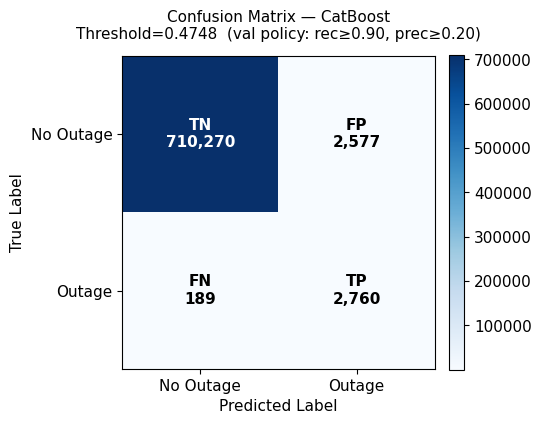

TN=710,270  FP=2,577  FN=189  TP=2,760
Precision=0.5171  Recall=0.9359  F1=0.6662


In [131]:
# Compute confusion matrix
cm = confusion_matrix(y_te, y_pred_best)
tn, fp, fn, tp = cm.ravel()
labels = np.array([["TN", "FP"], ["FN", "TP"]])

# Plot the matrix manually
fig, ax = plt.subplots(figsize=(5.5, 5))
im = ax.imshow(cm, interpolation='nearest', cmap="Blues")

# Label axes
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["No Outage", "Outage"], fontsize=11)
ax.set_yticklabels(["No Outage", "Outage"], fontsize=11)
ax.set_xlabel("Predicted Label", fontsize=11)
ax.set_ylabel("True Label", fontsize=11)

# Title with context
ax.set_title(
    f"Confusion Matrix — {best_name}\n"
    f"Threshold={best_thr:.4f}  "
    f"(val policy: rec≥{chosen_ops[best_name]['target_recall']:.2f}, "
    f"prec≥{chosen_ops[best_name]['min_precision']:.2f})",
    fontsize=11, pad=12
)

# Add annotations with dynamic color contrast
for (i, j), value in np.ndenumerate(cm):
    color = "white" if value > cm.max() / 2 else "black"
    ax.text(j, i, f"{labels[i,j]}\n{value:,}",
            ha='center', va='center', fontsize=11, fontweight='bold', color=color)

# Optional colorbar for reference
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# Compute and print summary metrics
prec = tp / max(tp + fp, 1)
rec  = tp / max(tp + fn, 1)
f1   = (2 * prec * rec) / max(prec + rec, 1e-12)

print(f"TN={tn:,}  FP={fp:,}  FN={fn:,}  TP={tp:,}")
print(f"Precision={prec:.4f}  Recall={rec:.4f}  F1={f1:.4f}")

## PR Curve

In [132]:
proba_te_best = best_model.predict_proba(Xt_best)[:, 1]

In [133]:
# Compute precision–recall curve
p, r, thr = precision_recall_curve(y_te, proba_te_best)
ap = average_precision_score(y_te, proba_te_best)

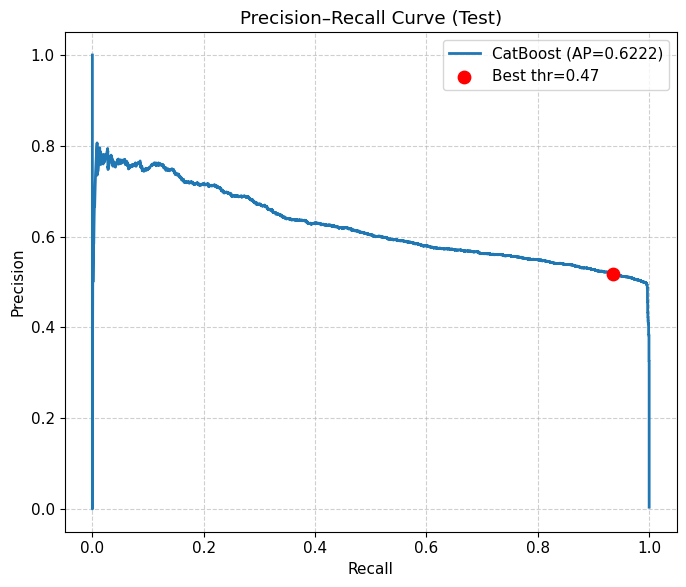

In [134]:
# Find the precision and recall corresponding to the chosen threshold
# (Note: thresholds returned by precision_recall_curve are for proba >= thr)
idx = np.argmin(np.abs(thr - best_thr))  # closest threshold
best_p, best_r = p[idx], r[idx]

# Plot
plt.figure(figsize=(7, 6))
plt.plot(r, p, label=f"{best_name} (AP={ap:.4f})", lw=2)
plt.scatter(best_r, best_p, color="red", s=80, zorder=5, label=f"Best thr={best_thr:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Test)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Feature Importance

Build a feature-named DataFrame for the test split Xt_best
- Logistic branch uses scaled arrays with VIF-pruned columns
- Trees/Boosters use full DataFrame with original columns

In [135]:
if best_name == "Logistic":
    # Xt_best is a scaled array; wrap with feature_cols_all names
    Xt_best_df = pd.DataFrame(Xt_best, columns=feature_cols_all)
else:
    # Xt_best is already a DataFrame with full feature columns
    Xt_best_df = Xt_best.copy()

In [136]:
# # Sample tail for speed
# pi_n = min(20000, len(Xt_best_df))
# X_pi = Xt_best_df.iloc[-pi_n:].copy()
# y_pi = y_te.iloc[-pi_n:].copy()

In [137]:
X_pi = Xt_best_df.copy()
y_pi = y_te.copy()

perm = permutation_importance(
    best_model, X_pi, y_pi,
    n_repeats=3, random_state=RANDOM_STATE, n_jobs=-1,
    scoring="average_precision"
)

imp = pd.DataFrame({
    "feature": X_pi.columns,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False)

print(f"Best model: {best_name}")
print(imp.head(15))

Best model: CatBoost
                             feature  importance_mean  importance_std
1                   trap_trend_score            0.405           0.000
5                  temperature_avg_c            0.254           0.000
0                  offline_ont_ratio            0.188           0.005
18   offline_ont_now_log_roll6h_mean            0.105           0.002
23  offline_ont_now_log_roll24h_mean            0.017           0.004
13      offline_ont_now_log_delta_1h            0.006           0.001
4                   rx_power_avg_dbm            0.002           0.001
20    bad_rsl_count_log_roll24h_mean            0.002           0.000
21  high_temp_count_log_roll24h_mean            0.002           0.000
7                           hour_cos            0.001           0.000
2                         fault_rate            0.001           0.000
19  link_loss_count_log_roll24h_mean            0.000           0.000
11      high_temp_count_log_delta_1h            0.000           0.000

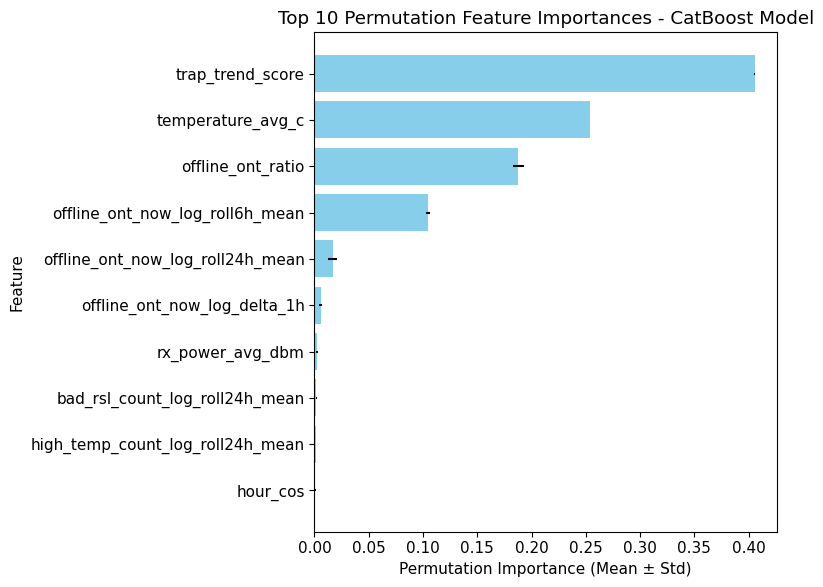

In [138]:
# Select top 10 features
imp_top10 = imp.head(10)

# Horizontal bar plot
plt.figure(figsize=(8, 6))
plt.barh(imp_top10["feature"], imp_top10["importance_mean"], xerr=imp_top10["importance_std"], color='skyblue')
plt.xlabel("Permutation Importance (Mean ± Std)")
plt.ylabel("Feature")
plt.title(f"Top 10 Permutation Feature Importances - {best_name} Model")
plt.gca().invert_yaxis()  # largest importance on top
plt.tight_layout()
plt.show()

# Save the Model

## Local

### Save

In [139]:
best_name

'CatBoost'

In [140]:
save_dir = "models"
os.makedirs(save_dir, exist_ok=True)

best_model, Xv_best, Xt_best = models[best_name]

model_path = os.path.join(save_dir, f"best_model_{best_name}.joblib")
joblib.dump(best_model, model_path)

print(f"✅ Saved best model ({best_name}) to: {model_path}")

✅ Saved best model (CatBoost) to: models\best_model_CatBoost.joblib


In [141]:
feat_info = {
    "model_name": best_name,
    "features": list(Xv_best.columns),
    "n_features": Xv_best.shape[1]
}

feat_path = os.path.join(save_dir, f"best_model_{best_name}_features.json")

with open(feat_path, "w") as f:
    json.dump(feat_info, f, indent=2)

print("✅ Saved feature metadata:", feat_path)

✅ Saved feature metadata: models\best_model_CatBoost_features.json


### Load

In [142]:
# model_name = "best_model_LightGBM"  # example
# model = joblib.load(f"models/{model_name}.joblib")

# # Load feature metadata
# with open(f"models/{model_name}_features.json") as f:
#     meta = json.load(f)
# features = meta["features"]

# print(f"Loaded {meta['model_name']} with {meta['n_features']} features.")

### Inference

In [143]:
# # Example: predict on new data
# X_new = pd.DataFrame([...], columns=features)  # your preprocessed inputs
# proba = model.predict_proba(X_new)[:, 1]
# pred = (proba >= 0.5).astype(int)

## Snowflake

### Save

In [153]:
from dotenv import load_dotenv
from snowflake.snowpark import Session
from snowflake.ml.registry import Registry
from snowflake.ml.model import task

In [145]:
load_dotenv()  # loads .env

True

In [146]:
account   = os.getenv("SNOWFLAKE_ACCOUNT")
user      = os.getenv("SNOWFLAKE_USER")
password  = os.getenv("SNOWFLAKE_PASSWORD")
role      = os.getenv("SNOWFLAKE_ROLE")
warehouse = os.getenv("SNOWFLAKE_WAREHOUSE")
database  = os.getenv("SNOWFLAKE_DATABASE")
schema    = os.getenv("SNOWFLAKE_SCHEMA")

In [148]:
conn = {
    "account": account,
    "user": user,
    "password": password,
    "role": role,
    "warehouse": warehouse,
    "database": database,
    "schema": schema
}

In [149]:
session = Session.builder.configs(conn).create()

In [150]:
# Use the feature order I'll require in Snowflake:
feature_order = feature_cols_all[:]   # keep a copy

# Build a single object with predict_proba that accepts a DataFrame with these columns
if best_name == "Logistic":
    from sklearn.pipeline import make_pipeline
    # Refit the exact sequence you used: scaler -> logistic -> calibrator
    pipe = make_pipeline(StandardScaler(with_mean=True, with_std=True), best_logit)
    pipe.fit(X_tr[feature_order], y_tr)
    final_model = CalibratedClassifierCV(pipe, cv="prefit", method="sigmoid")
    final_model.fit(X_cal[feature_order], y_cal)
elif best_name == "XGBoost":
    final_model = cal_xgb  # already fitted on full train + calibrated on cal
elif best_name == "LightGBM":
    final_model = cal_lgb
elif best_name == "CatBoost":
    final_model = cal_cat
else:
    final_model = cal_dt  # DecisionTree case

In [151]:
final_model

,estimator,<catboost.cor...00204AC346860>
,method,'sigmoid'
,cv,'prefit'
,n_jobs,None
,ensemble,'auto'


In [152]:
_ = final_model.predict_proba(X_te[feature_order])

Log the model to the Snowflake Model Registry

In [156]:
session.sql("CREATE DATABASE IF NOT EXISTS ANALYTICS").collect()

[Row(status='Database ANALYTICS successfully created.')]

In [157]:
session.sql("CREATE SCHEMA IF NOT EXISTS ANALYTICS.ML_REGISTRY").collect()

[Row(status='Schema ML_REGISTRY successfully created.')]

In [158]:
session.sql("USE DATABASE ANALYTICS").collect()

[Row(status='Statement executed successfully.')]

In [159]:
session.sql("USE SCHEMA ML_REGISTRY").collect()

[Row(status='Statement executed successfully.')]

In [160]:
reg = Registry(session=session, database_name="ANALYTICS", schema_name="ML_REGISTRY")

In [161]:
version = pd.Timestamp.now().strftime("v%Y%m%d_%H%M")
model_name = "OUTAGE_CLASSIFIER"

In [162]:
sample_input = X_te[feature_order].head(5)  # tiny schema sample

deps = ["scikit-learn", "xgboost", "lightgbm", "catboost", "pandas", "numpy"]

metrics = {
    "roc_auc_test": float(results_df.loc[results_df['model']==best_name, 'roc_auc_test'].iloc[0]),
    "pr_auc_test":  float(results_df.loc[results_df['model']==best_name, 'pr_auc_test'].iloc[0]),
    "decision_threshold": float(best_thr),
    "policy": {
        "target_recall": float(chosen_ops[best_name]["target_recall"]),
        "min_precision": float(chosen_ops[best_name]["min_precision"])
    },
    "feature_order": feature_order
}

In [163]:
mv = reg.log_model(
    final_model,
    model_name=model_name,
    version_name=version,
    conda_dependencies=deps,
    comment=f"{best_name} with calibration, logged from notebook",
    metrics=metrics,
    sample_input_data=sample_input,
    task=task.Task.TABULAR_BINARY_CLASSIFICATION
)

Logging model: creating model manifest...:  33%|█████████████▋                           | 2/6 [00:04<00:09,  2.36s/it]


PermutationExplainer explainer:  80%|█████████████████████████████████████████▌          | 4/5 [00:16<00:00, 19.50it/s]
PermutationExplainer explainer: 6it [00:17,  3.43s/it]                                                                 


Model logged successfully.: 100%|████████████████████████████████████████████████████████| 6/6 [02:49<00:00, 28.27s/it]


### Load

In [164]:
session.sql("USE DATABASE ANALYTICS").collect()

[Row(status='Statement executed successfully.')]

In [165]:
session.sql("USE SCHEMA ML_REGISTRY").collect()

[Row(status='Statement executed successfully.')]

In [166]:
reg = Registry(session=session)  # uses current DB/Schema context

model_name = "OUTAGE_CLASSIFIER"  # the name you used when logging

# Option A: load the default version
model = reg.get_model(model_name)
mv = model.default  # a ModelVersion object

In [167]:
print("Model name:", model.name)
print("Default version:", model.default.version_name)

all_versions = model.versions()  # <-- call it
print("All versions:", [v.version_name for v in all_versions])

Model name: OUTAGE_CLASSIFIER
Default version: V20251027_1338
All versions: ['V20251027_1338']


In [168]:
metrics = mv.show_metrics()              # returns dict of what you logged
thr = float(metrics.get("decision_threshold", 0.5))
feature_order = metrics.get("feature_order")
print(thr, len(feature_order))

0.4748477350130987 24


In [170]:
session.sql("CREATE SCHEMA IF NOT EXISTS ANALYTICS.FEATURES").collect()

[Row(status='Schema FEATURES successfully created.')]

In [171]:
session.write_pandas(
    df=test_f[feature_cols_all].reset_index(),  # or whatever DataFrame you want to score
    table_name="OUTAGE_FEATURES_1H",
    database="ANALYTICS",
    schema="FEATURES",
    auto_create_table=True,
    overwrite=True
)

**Build the feature DataFrame (ordered + numeric)**

In [175]:
from snowflake.snowpark import functions as F

SOURCE_TABLE = "ANALYTICS.FEATURES.OUTAGE_FEATURES_1H"
sp_df_raw = session.table(SOURCE_TABLE)

In [176]:
sp_df_raw = session.table("ANALYTICS.FEATURES.OUTAGE_FEATURES_1H")
print([c.name for c in sp_df_raw.schema.fields])

['"index"', '"offline_ont_ratio"', '"trap_trend_score"', '"fault_rate"', '"snr_avg"', '"rx_power_avg_dbm"', '"temperature_avg_c"', '"hour_sin"', '"hour_cos"', '"is_maintenance_window"', '"link_loss_count_log_delta_1h"', '"bad_rsl_count_log_delta_1h"', '"high_temp_count_log_delta_1h"', '"dying_gasp_count_log_delta_1h"', '"offline_ont_now_log_delta_1h"', '"link_loss_count_log_roll6h_mean"', '"bad_rsl_count_log_roll6h_mean"', '"high_temp_count_log_roll6h_mean"', '"dying_gasp_count_log_roll6h_mean"', '"offline_ont_now_log_roll6h_mean"', '"link_loss_count_log_roll24h_mean"', '"bad_rsl_count_log_roll24h_mean"', '"high_temp_count_log_roll24h_mean"', '"dying_gasp_count_log_roll24h_mean"', '"offline_ont_now_log_roll24h_mean"']


In [177]:
# Build map {lower_noquotes -> actual_name_as_stored}
def norm(name: str) -> str:
    return name.strip('"').lower()

colmap = {norm(c.name): c.name for c in sp_df_raw.schema.fields}

In [178]:
# Make sure every expected feature exists (case/quote-insensitive)
missing = [f for f in feature_order if norm(f) not in colmap]
if missing:
    raise ValueError(f"Missing feature columns (by case-insensitive match): {missing}")

In [179]:
# Select in model order, aliasing back to the plain feature name
mapped_cols = [F.col(colmap[norm(f)]).alias(f) for f in feature_order]
sp_df = sp_df_raw.select(mapped_cols)

# Ensure numeric types
for f in feature_order:
    sp_df = sp_df.with_column(f, F.col(f).cast("DOUBLE"))

sp_df.show(5)

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"OFFLINE_ONT_RATIO"   |"TRAP_TREND_SCORE"     |"FAULT_RATE"           |"SNR_AVG"           |"RX_POWER_AVG_DBM"   |"TEMPERATURE_AVG_C"  |"HOUR_SIN"           |"HOUR_COS"          |"IS_MAINTENANCE_WINDOW"  |"LINK_LOSS_COUNT_LOG_DELTA_1H"  |"BAD_RSL_COUNT_LOG_DELTA_1H

### Inference

**Run the model in-warehouse and get probabilities**

In [182]:
funcs = mv.show_functions()
funcs

[{'name': 'EXPLAIN',
  'target_method': 'explain',
  'target_method_function_type': 'TABLE_FUNCTION',
  'signature': ModelSignature(
                      inputs=[
                          FeatureSpec(dtype=DataType.FLOAT, name='offline_ont_ratio', nullable=True),
  		FeatureSpec(dtype=DataType.FLOAT, name='trap_trend_score', nullable=True),
  		FeatureSpec(dtype=DataType.FLOAT, name='fault_rate', nullable=True),
  		FeatureSpec(dtype=DataType.FLOAT, name='snr_avg', nullable=True),
  		FeatureSpec(dtype=DataType.FLOAT, name='rx_power_avg_dbm', nullable=True),
  		FeatureSpec(dtype=DataType.FLOAT, name='temperature_avg_c', nullable=True),
  		FeatureSpec(dtype=DataType.FLOAT, name='hour_sin', nullable=True),
  		FeatureSpec(dtype=DataType.FLOAT, name='hour_cos', nullable=True),
  		FeatureSpec(dtype=DataType.FLOAT, name='is_maintenance_window', nullable=True),
  		FeatureSpec(dtype=DataType.FLOAT, name='link_loss_count_log_delta_1h', nullable=True),
  		FeatureSpec(dtype=DataType.FLOAT

**Run the desired function (probabilities)**

In [185]:
scored = mv.run(sp_df, function_name="predict_proba")
scored.show(5)

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"OFFLINE_ONT_RATIO"   |"TRAP_TREND_SCORE"     |"FAULT_RATE"           |"SNR_AVG"           |"RX_POWER_AVG_DBM"   |"TEMPERATURE_AVG_C"  |"HOUR_SIN"           |"HOUR_COS"          |"IS_MAINTENANCE_WINDOW"  |"LINK_LOSS_COU

In [190]:
last_cols = scored.columns[-5:]
scored.select(last_cols).show(5)

---------------------------------------------------------------------------------------------------------------------------------------------------------------
|"HIGH_TEMP_COUNT_LOG_ROLL24H_MEAN"  |"DYING_GASP_COUNT_LOG_ROLL24H_MEAN"  |"OFFLINE_ONT_NOW_LOG_ROLL24H_MEAN"  |"OUTPUT_FEATURE_0"  |"OUTPUT_FEATURE_1"      |
---------------------------------------------------------------------------------------------------------------------------------------------------------------
|0.2888113252333105                  |0.17328679513998665                  |1.107686842215611                   |0.9999588536327287  |4.114636727128213e-05   |
|0.16130004212116217                 |0.2021679276633174                   |0.9066927010925728                  |0.9999588535844512  |4.11464155487018e-05    |
|0.1781944216256693                  |0.27682457221448636                  |0.935241826547188                   |0.9999588535583214  |4.114644167857711e-05   |
|0.36346796978447954                 |0.

In [186]:
print("Scored columns:", scored.schema.names)

Scored columns: ['OFFLINE_ONT_RATIO', 'TRAP_TREND_SCORE', 'FAULT_RATE', 'SNR_AVG', 'RX_POWER_AVG_DBM', 'TEMPERATURE_AVG_C', 'HOUR_SIN', 'HOUR_COS', 'IS_MAINTENANCE_WINDOW', 'LINK_LOSS_COUNT_LOG_DELTA_1H', 'BAD_RSL_COUNT_LOG_DELTA_1H', 'HIGH_TEMP_COUNT_LOG_DELTA_1H', 'DYING_GASP_COUNT_LOG_DELTA_1H', 'OFFLINE_ONT_NOW_LOG_DELTA_1H', 'LINK_LOSS_COUNT_LOG_ROLL6H_MEAN', 'BAD_RSL_COUNT_LOG_ROLL6H_MEAN', 'HIGH_TEMP_COUNT_LOG_ROLL6H_MEAN', 'DYING_GASP_COUNT_LOG_ROLL6H_MEAN', 'OFFLINE_ONT_NOW_LOG_ROLL6H_MEAN', 'LINK_LOSS_COUNT_LOG_ROLL24H_MEAN', 'BAD_RSL_COUNT_LOG_ROLL24H_MEAN', 'HIGH_TEMP_COUNT_LOG_ROLL24H_MEAN', 'DYING_GASP_COUNT_LOG_ROLL24H_MEAN', 'OFFLINE_ONT_NOW_LOG_ROLL24H_MEAN', 'OUTPUT_FEATURE_0', 'OUTPUT_FEATURE_1']


**Pick the probability column, threshold, and save**

In [187]:
from snowflake.snowpark import functions as F

# Choose a sensible column (common names first, else first float)
preferred = ["PREDICTION", "OUTPUT", "PROBABILITY", "predict_proba"]
proba_col = next((n for n in scored.schema.names if n in preferred), None)
if proba_col is None:
    float_cols = [n for n, f in zip(scored.schema.names, scored.schema.fields)
                  if f.datatype.__class__.__name__ in ("DoubleType","FloatType")]
    proba_col = float_cols[0]  # assumes at least one float present

pred_df = scored.with_column("pred_label", (F.col(proba_col) >= F.lit(thr)).cast("INTEGER"))

In [191]:
session.sql("CREATE SCHEMA IF NOT EXISTS ANALYTICS.SCORES").collect()
TARGET_TABLE = "ANALYTICS.SCORES.OUTAGE_SCORED_1H"
pred_df.write.mode("overwrite").save_as_table(TARGET_TABLE)

In [193]:
zf = session.table(TARGET_TABLE)
last_cols = zf.columns[-3:]
zf.select(last_cols).show(10)

--------------------------------------------------------------
|"OUTPUT_FEATURE_0"  |"OUTPUT_FEATURE_1"      |"PRED_LABEL"  |
--------------------------------------------------------------
|0.9999588535737317  |4.1146426268332734e-05  |0             |
|0.9999587727413265  |4.1227258673498525e-05  |0             |
|0.999958853689951   |4.11463100490014e-05    |0             |
|0.9999588536497585  |4.1146350241513365e-05  |0             |
|0.9999588536715011  |4.114632849893115e-05   |0             |
|0.9999588536652985  |4.114633470157302e-05   |0             |
|0.9999588531248531  |4.114687514687201e-05   |0             |
|0.9999588536085608  |4.1146391439113466e-05  |0             |
|0.9999588534743895  |4.114652561047426e-05   |0             |
|0.9999588534615814  |4.1146538418553735e-05  |0             |
--------------------------------------------------------------

